# **Proyecto Inmobiliario Versión 2**

### Importamos Librerías y descargamos el dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Librerias a instalar
import sys
#!{sys.executable} -m pip install pandas-profiling 
import pandas_profiling as pdp
import gc
gc.enable()
from pandas import plotting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Proyecto 1 DS/DS_Proyecto_01_Datos_Properati.csv')

Analizaremos que tipos de variables son los features contenidos en nuestro datset

In [ ]:
df.dtypes

start_date          object
end_date            object
created_on          object
lat                float64
lon                float64
l1                  object
l2                  object
l3                  object
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
title               object
description         object
property_type       object
operation_type      object
dtype: object

Los primeros tres features los podemos convertir a datetime64[ns] pero de momento no analizaremos series de tiempo, así que no los modificaremos.

Por lo tanto, los únicos atributos que modificaremos son 'rooms', 'bedrooms', 'bathrooms'. Ya que no tiene sentido que cualquiera de estas instancias tomen un valor que no sea entero.

Pero antes de realizar el spell, nos debemos asegurar de que no hayan missing values.

In [ ]:
  ''' 
        Ejecutar después de imputar los valores 
  '''
df['rooms'] = df['rooms'].astype(int)
df['bedrooms'] = df['bedrooms'].astype(int)
#df['bathrooms'] = df['bathrooms'].astype(int)

Nos vamos a quedar unicamente con 3 tipos de propiedades. **Departamentos, PH y Casas.**

In [ ]:
print(df.shape[0])
df = df[df.property_type.isin(['PH', 'Departamento', 'Casa'])]
print(df.shape[0])

146660
143145


# **Parte A**

## **I- Duplicados e Inconsistencias**

Voy a eliminar las instancias que están EXACTAMENTE duplicadas.

In [ ]:
print(df.shape[0], 'instancias iniciales')

143145 instancias iniciales


In [ ]:
#Eliminación de instancias exactamente duplicadas
a=df.shape[0]
df.drop(df[df.duplicated()].index,inplace=True)
d=df.shape[0]
print(a-d,'instancias eliminadas que eran exactamente iguales')

2323 instancias eliminadas que eran exactamente iguales


In [ ]:
dfx= df.copy()
dfx.shape

(140822, 19)

In [ ]:
inc=dfx[(dfx['surface_covered'] > dfx['surface_total'])]
inc.shape[0]

1419

Eliminaremos las instancias en donde, superficie es mayor  a superficie total.

In [ ]:
#Eliminacion de instancias donde superficie_cubierta > superficie total
a=df.shape[0]
df=df.drop(inc.index,axis=0)
d=df.shape[0]
print(a-d,'instancias eliminadas que eran inconcistentes')

1419 instancias eliminadas que eran inconcistentes


In [ ]:
print(df.shape[0], 'instancias finales')

139403 instancias finales


## **II - Drop irrelevant features**


Por otro lado, eliminaremos las columnas que, para este análisis puntual no son relevantes. `'start_date', 'end_date', 'created_on', 'currency', 'title', 'description'` y `'operation_type'`.

In [ ]:
df=df.drop(['start_date', 'end_date', 'created_on', 'currency',
            'title', 'description', 'operation_type','l1'], axis=1)
df.head()

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,-34.605880,-58.384949,Capital Federal,San Cristobal,7,7,2.0,140.0,140.0,153000.0,Departamento
1,-34.624056,-58.412110,Capital Federal,Boedo,2,1,2.0,70.0,58.0,159000.0,PH
2,-34.593569,-58.427474,Capital Federal,Palermo,2,1,1.0,45.0,45.0,125000.0,PH
3,-34.581294,-58.436754,Capital Federal,Palermo,2,1,1.0,85.0,50.0,295000.0,PH
4,-34.914194,-57.938219,Bs.As. G.B.A. Zona Sur,La Plata,2,1,1.0,50.0,35.0,40000.0,PH


## **III - Missing Values**

In [ ]:
ant= df.shape[0]
print(ant, 'Instancias previas a la etapa')

139403 Instancias previas a la etapa


Primero, contamos cuantos nulos por columna hay.

In [ ]:
missing= df.apply(lambda x: sum(x.isnull()),axis=0)
print(missing)

lat                 9225
lon                 9256
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           4169
surface_total      18369
surface_covered    18646
price                  0
property_type          0
dtype: int64


Vemos que hay algunas columnas o features, que presentan valores faltantes. Latitud, Longitud, Baños, Superficie Total y Superficie Cubierta.

Qué será mejor, eliminarlos o imputarlos?

Para responder esto, primero hay que ver que porcentaje de nuestros datos representan y analizar las razones del missing value.


In [ ]:
missing = pd.DataFrame(df.isna().sum())
missing= missing.reset_index()
missing.columns=['feature','q_missing']
missing

,feature,q_missing
0,lat,9225
1,lon,9256
2,l2,0
3,l3,0
4,rooms,0
5,bedrooms,0
6,bathrooms,4169
7,surface_total,18369
8,surface_covered,18646
9,price,0


Analicemos, qué porcentaje representan los valores faltantes por grupo

In [ ]:
for i in missing.index:
  if missing['q_missing'][i] >0:
    per= (missing['q_missing'][i]/df.shape[0])*100
    per = "{0:.2f}%".format(per)
    print('Lo valores faltantes de la columna "',missing['feature'][i],
          '" representan el',per,'de todas las instancias')

Lo valores faltantes de la columna " lat " representan el 6.62% de todas las instancias
Lo valores faltantes de la columna " lon " representan el 6.64% de todas las instancias
Lo valores faltantes de la columna " bathrooms " representan el 2.99% de todas las instancias
Lo valores faltantes de la columna " surface_total " representan el 13.18% de todas las instancias
Lo valores faltantes de la columna " surface_covered " representan el 13.38% de todas las instancias


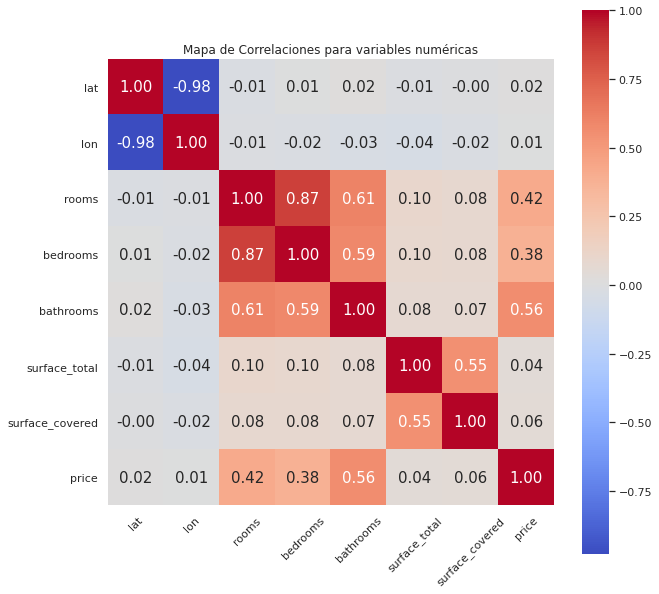

In [ ]:
#HeatMap de correlaciones para ver que que variables numéricas harían un buen KNN Imputer en Latitud, Longitud, Baños, Superficie Total y Superficie Cubierta.
corr= df.drop(['l2','l3','property_type'],axis=1).corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, 
            xticklabels= df.drop(['l2','l3','property_type'],axis=1).columns, 
            yticklabels= df.drop(['l2','l3','property_type'],axis=1).columns,
            cmap= 'coolwarm')
plt.title('Mapa de Correlaciones para variables numéricas')
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)
plt.show()

* Podemos ver que Latitud y Longitud , que representan un 6,56% y un  6,58%, respectivamente, imputar sus faltantes, no conllevaría un sesgo en nustros datos. Al no tener correlación con ningún feature, imputarlos con un KNN Imputer no sería la mejor estrategia. Por esto, voy a imputar los valores faltantes con el promedio de latitud y longitud de la ciudad `('l2')` en la que se encuentra esa instancia.

* Por otra parte, Rooms, Bedrooms y Bathrooms, se explican muy bien entre ellos, por lo que aplicar un KNN Imputer entre ellos para poder hallar los bathrooms faltantes, parecer ser una buena estrategia.

* Finalmente, Superficie Total y Superficie Cubierta solo tienen correlación entre ellos, por lo que si quisieramos aplicar KNN Imputer, y se da la casualidad de que para 'x' instancia hay missing tanto en superifice total, como en superifice cubierta, esta opción no sería viable. Por lo podríamos agrupar los faltantes de las superficies y la de los baños, y realizar un KNN Imputer en conjunto.

### **1- Valores Faltantes en Latitud y Longitud**

Debido a la baja cantidad (6,77 y 6,79%), imputar estos valores no va a generar un sesgo muy alto en nuestro dataset. Imputaremos los valores faltantes con el promedio de la latitud y longitud de la Ciudad en la que se encuentren.

In [ ]:
#Hallar la latitud promedio según su ciudad
latitudes = df.groupby('l2')['lat'].mean().to_frame('lat')
latitudes = latitudes.reset_index(level='l2', col_level=1)
latitudes.head()

,l2,lat
0,Bs.As. G.B.A. Zona Norte,-34.465059
1,Bs.As. G.B.A. Zona Oeste,-34.639961
2,Bs.As. G.B.A. Zona Sur,-34.786969
3,Capital Federal,-34.599037


In [ ]:
#Hallar la longitud promedio según su ciudad
longitudes = df.groupby('l2')['lon'].mean().to_frame('lon')
longitudes=longitudes.reset_index(level='l2', col_level=1)
longitudes.head()

,l2,lon
0,Bs.As. G.B.A. Zona Norte,-58.639224
1,Bs.As. G.B.A. Zona Oeste,-58.614438
2,Bs.As. G.B.A. Zona Sur,-58.283556
3,Capital Federal,-58.435970


In [ ]:
# Generamos una máscara por ciudad
df_1= df[df['l2']=='Bs.As. G.B.A. Zona Norte']
df_2= df[df['l2']=='Bs.As. G.B.A. Zona Oeste']
df_3= df[df['l2']=='Bs.As. G.B.A. Zona Sur']
df_4= df[df['l2']=='Capital Federal']

In [ ]:
# Llenamos cada una de las máscaras con el promedio de su lat y lon
df_1.lat.fillna(df_1.lat.mean(),inplace = True)
df_1.lon.fillna(df_1.lon.mean(),inplace = True)
df_2.lat.fillna(df_2.lat.mean(),inplace = True)
df_2.lon.fillna(df_2.lon.mean(),inplace = True)
df_3.lat.fillna(df_3.lat.mean(),inplace = True)
df_3.lon.fillna(df_3.lon.mean(),inplace = True)
df_4.lat.fillna(df_4.lat.mean(),inplace = True)
df_4.lon.fillna(df_4.lon.mean(),inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
# Concatenamos las máscaras para volver a tener todo en una misma base de datos
df=pd.concat([df_1,df_2], ignore_index=True) 
df=pd.concat([df,df_3], ignore_index=True) 
df=pd.concat([df,df_4], ignore_index=True) 

In [ ]:
missing= df.apply(lambda x: sum(x.isnull()),axis=0)
print(missing)

lat                    0
lon                    0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           4169
surface_total      18369
surface_covered    18646
price                  0
property_type          0
dtype: int64


Ya no tenemos valores faltantes en los features `lat` y `lon`

### **2- Valores Faltantes en Baños, Superifice Total y Superifice Cubierta**

En esta sección me propongo usar un KNNImputer para imputar los datos faltantes entre baños, superifice total y superficie cubierta.  Para esto, le pasaré al imputer los features de: 'rooms' , 'bedrooms', 'bathrooms' 'surface_total', 'surface_covered'

In [ ]:
missing= df.apply(lambda x: sum(x.isnull()),axis=0)
print(missing)
d=df.shape[0]
print('Se han eliminado', ant-d,'instancias')

lat                    0
lon                    0
l2                     0
l3                     0
rooms                  0
bedrooms               0
bathrooms           4169
surface_total      18369
surface_covered    18646
price                  0
property_type          0
dtype: int64
Se han eliminado 0 instancias


Para verificar a simple vista si los valores imputados son lógicos o descentes, primero voy a crear una lista de los indices cuyas instancias tienen al menos un valor faltante.

In [ ]:
# Vamos a crear diferentes sets para averiguar las filas en las que faltan al 
# menos un valor de baño / superifice total/ o superficie cubierta 
mst= df[df.surface_total.isnull()]
msc= df[df.surface_covered.isnull()]
mb= df[df.bathrooms.isna()]
mb_list=[]
for i in mb.index:
  mb_list.append(i)
print(len(mb_list))
mst_list=[]
for i in mst.index:
  mst_list.append(i)
print(len(mst_list))
msc_list=[]
for i in msc.index:
   msc_list.append(i)
print(len(msc_list))
mb_list=set(mb_list)
mst_list=set(mst_list)
msc_list=set(msc_list)
missing_rows= mb_list |  mst_list | msc_list # Obtenemos la union del espacio de los tres sets
print('Nuestro espacio missing tiene',len(missing_rows),'filas')

4169
18369
18646
Nuestro espacio missing tiene 20812 filas


El siguiente dataframe nos va a servir como punto de comparación con las instancias imputadas. Se puede ver los NaN en cada fila.

In [ ]:
#Acá podemos ver que tenemos al menos un dato faltante por instancia.
# Vamos a usar esto para poder verificar que el imputador haya realizado un desempeño descente

df.loc[missing_rows]

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
131078,-34.614112,-58.429934,Capital Federal,Caballito,2,1,1.0,NaN,43.0,110000.0,Departamento
143,-34.465059,-58.639224,Bs.As. G.B.A. Zona Norte,Escobar,4,3,NaN,686.0,686.0,298000.0,Casa
148,-34.590816,-58.544412,Bs.As. G.B.A. Zona Norte,General San Martín,4,3,NaN,130.0,130.0,98000.0,Casa
158,-34.465059,-58.639224,Bs.As. G.B.A. Zona Norte,Escobar,5,4,NaN,75792.0,75792.0,580000.0,Casa
160,-34.465059,-58.639224,Bs.As. G.B.A. Zona Norte,Escobar,5,4,NaN,731.0,731.0,498000.0,Casa
...,...,...,...,...,...,...,...,...,...,...,...
65098,-34.641213,-58.505128,Capital Federal,Villa Luro,3,2,1.0,61.0,NaN,145000.0,Departamento
65116,-34.640748,-58.495833,Capital Federal,Villa Luro,4,3,NaN,90.0,75.0,160000.0,Departamento
130681,-34.559440,-58.481742,Capital Federal,Coghlan,4,3,NaN,166.0,154.0,770000.0,Departamento
131022,-34.599037,-58.435970,Capital Federal,Congreso,2,1,1.0,34.0,NaN,70000.0,Departamento


Antes de Imputar los datos, vamos a escalarlos para que las distancias de los K-Neighbour sean uniformes

In [ ]:
#Primero, vamos a escalar los datos
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [ ]:
#Primero, vamos a escalar los datos
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
df[['bathrooms','rooms','bedrooms','surface_total','surface_covered']] = scaler.fit_transform(df[['bathrooms','rooms','bedrooms','surface_total','surface_covered']])
round(df.describe(),2)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,139403.00,139403.00,139403.00,139403.00,135234.00,121034.00,120757.00,139403.00
mean,-34.60,-58.47,0.00,0.00,0.00,-0.00,0.00,237203.63
std,0.46,0.48,1.00,1.00,1.00,1.00,1.00,283632.00
min,-35.15,-180.00,-1.51,-1.78,-0.67,-0.12,-0.14,6000.00
25%,-34.63,-58.51,-0.79,-0.89,-0.67,-0.09,-0.08,112000.00
50%,-34.60,-58.44,-0.07,0.00,-0.67,-0.07,-0.05,165000.00
75%,-34.57,-58.41,0.66,0.89,0.46,-0.03,0.00,263000.00
max,85.05,-57.81,23.08,11.58,14.05,115.89,169.62,32434232.00


In [ ]:
%%time
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2,weights='uniform',metric='nan_euclidean')
x= df[['bathrooms','rooms','bedrooms','surface_total','surface_covered']]
x=imputer.fit_transform(x)
df.loc[:,['bathrooms','rooms','bedrooms','surface_total','surface_covered']]= x

CPU times: user 4min 54s, sys: 11.6 s, total: 5min 6s
Wall time: 4min 42s


Una vez imputados los datos, desescalamos el dataframe para poder apreciar las diferentes magnitudes de los features imputados

In [ ]:
df[['bathrooms','rooms','bedrooms','surface_total','surface_covered']]=scaler.inverse_transform(df[['bathrooms','rooms','bedrooms','surface_total','surface_covered']])

Ahora la comparación:

In [ ]:
 df.loc[missing_rows]

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
131078,-34.614112,-58.429934,Capital Federal,Caballito,2.0,1.0,1.0,49.5,43.0,110000.0,Departamento
143,-34.465059,-58.639224,Bs.As. G.B.A. Zona Norte,Escobar,4.0,3.0,2.5,686.0,686.0,298000.0,Casa
148,-34.590816,-58.544412,Bs.As. G.B.A. Zona Norte,General San Martín,4.0,3.0,3.0,130.0,130.0,98000.0,Casa
158,-34.465059,-58.639224,Bs.As. G.B.A. Zona Norte,Escobar,5.0,4.0,4.0,75792.0,75792.0,580000.0,Casa
160,-34.465059,-58.639224,Bs.As. G.B.A. Zona Norte,Escobar,5.0,4.0,4.0,731.0,731.0,498000.0,Casa
...,...,...,...,...,...,...,...,...,...,...,...
65098,-34.641213,-58.505128,Capital Federal,Villa Luro,3.0,2.0,1.0,61.0,52.0,145000.0,Departamento
65116,-34.640748,-58.495833,Capital Federal,Villa Luro,4.0,3.0,3.0,90.0,75.0,160000.0,Departamento
130681,-34.559440,-58.481742,Capital Federal,Coghlan,4.0,3.0,3.0,166.0,154.0,770000.0,Departamento
131022,-34.599037,-58.435970,Capital Federal,Congreso,2.0,1.0,1.0,34.0,1.0,70000.0,Departamento


Podemos ver que la imputación ha sido bastante acorde a lo que se esperaba. Por ejemplo, la primer instancia se imputó 49.5 m2 de superifice total. 

Ahora y finalmente, debido a que no tenemos missings en bathrooms, podemos convertir el data type a 'int'

In [ ]:
df['bathrooms']= df['bathrooms'].astype(int)

## **IV - Detección y Eliminación de Outliers**

Voy a utilizar el método 3 sigmas para la eliminación de valores atípicos. Ya que es una técnica mas rádical que la de IQR. 3 sigmas abarca el 99,73% de los datos.

### **1- Rooms, Bedrooms y Bathrooms**

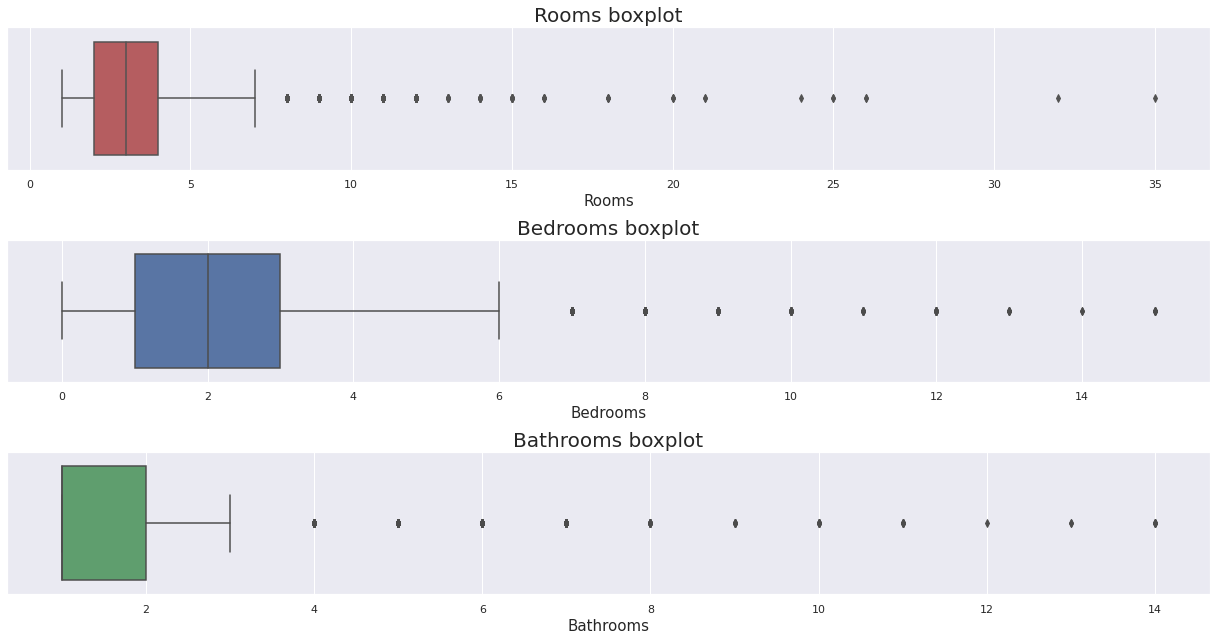

In [ ]:
plt.figure(figsize=(17,9))

plt.subplot(3,1,1)
plt.title('Rooms boxplot', fontsize=20)
sns.boxplot(data=df, x='rooms', color='r')
plt.xlabel('Rooms',fontsize=15)

plt.subplot(3,1,2)
plt.title('Bedrooms boxplot', fontsize=20)
sns.boxplot(data=df, x='bedrooms', color='b')
plt.xlabel('Bedrooms',fontsize=15)

plt.subplot(3,1,3)
plt.title('Bathrooms boxplot', fontsize=20)
sns.boxplot(data=df, x='bathrooms', color='g')
plt.xlabel('Bathrooms',fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
lista = ['rooms','bedrooms','bathrooms'] #Iteramos sobre cada una de las features 
t=0 #Para acumular el total de instancias eliminadas por outliers
for i in lista:
  a=df.shape[0] #Cantidad de instancias inicial
  m=df[i].mean() #media
  std= df[i].std() #desviación estándar
  min= m - 3*std #mínimo
  max= m + 3*std #máximo
  df=df[(df[i]>min)&(df[i]<max)] #filtrado de exceso y defecto
  d=df.shape[0] #Cantidad de instancias finales
  e=a-d #total de filas eliminadas en iteración x
  t=t+e #total de filas eliminadas en todas las instancias
  print('Se eliminaron', e , 'instancias, debido a los outliers de la columna',i)
print('Se eliminaron un total de ',t,'instancias por los outliers de', lista)

Se eliminaron 1320 instancias, debido a los outliers de la columna rooms
Se eliminaron 502 instancias, debido a los outliers de la columna bedrooms
Se eliminaron 1153 instancias, debido a los outliers de la columna bathrooms
Se eliminaron un total de  2975 instancias por los outliers de ['rooms', 'bedrooms', 'bathrooms']


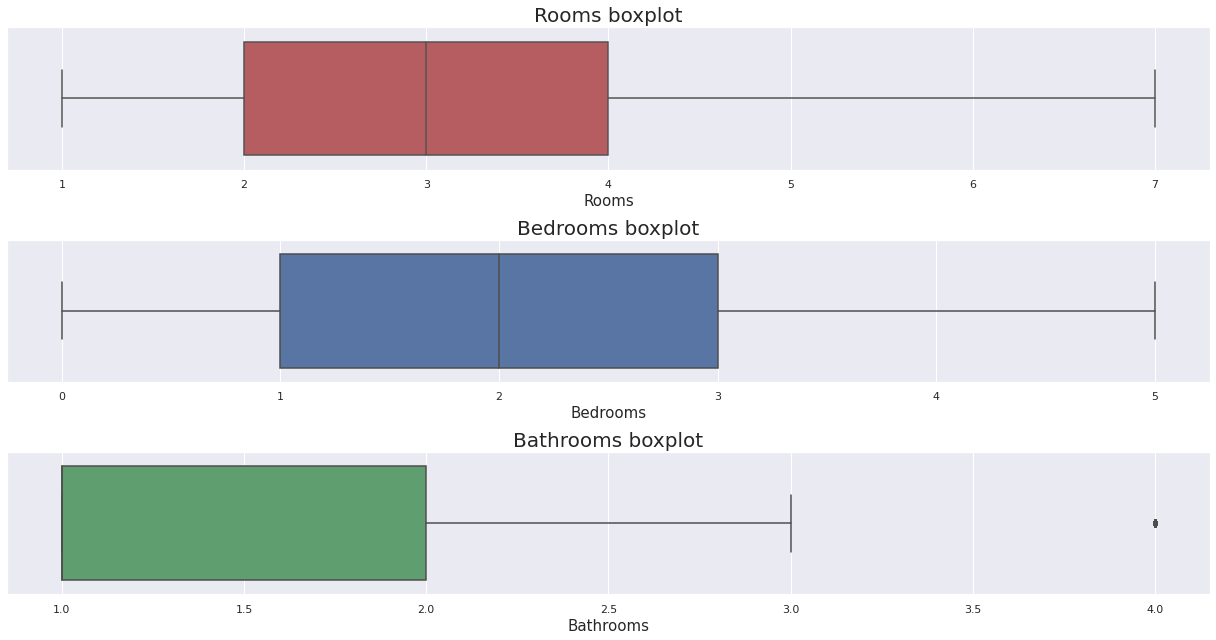

In [ ]:
plt.figure(figsize=(17,9))

plt.subplot(3,1,1)
plt.title('Rooms boxplot', fontsize=20)
sns.boxplot(data=df, x='rooms', color='r')
plt.xlabel('Rooms',fontsize=15)

plt.subplot(3,1,2)
plt.title('Bedrooms boxplot', fontsize=20)
sns.boxplot(data=df, x='bedrooms', color='b')
plt.xlabel('Bedrooms',fontsize=15)

plt.subplot(3,1,3)
plt.title('Bathrooms boxplot', fontsize=20)
sns.boxplot(data=df, x='bathrooms', color='g')
plt.xlabel('Bathrooms',fontsize=15)

plt.tight_layout()
plt.show()

### **2- Superficie Total, Superficie Cubierta y Precio**

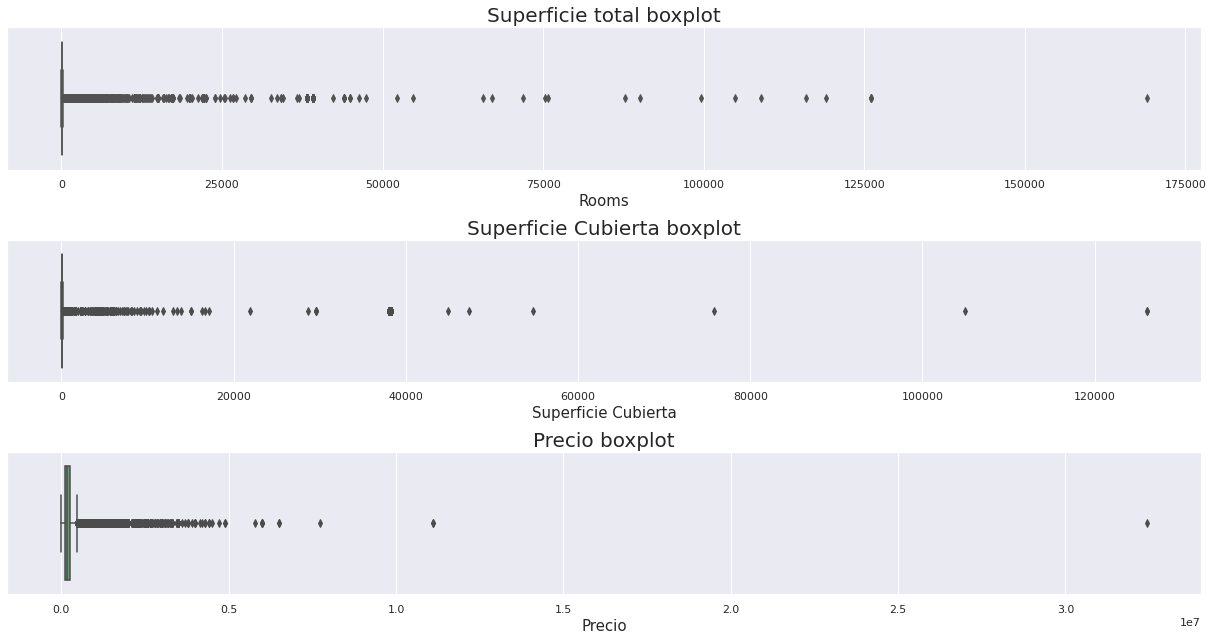

In [ ]:
plt.figure(figsize=(17,9))

plt.subplot(3,1,1)
plt.title('Superficie total boxplot', fontsize=20)
sns.boxplot(data=df, x='surface_total', color='r')
plt.xlabel('Rooms',fontsize=15)

plt.subplot(3,1,2)
plt.title('Superficie Cubierta boxplot', fontsize=20)
sns.boxplot(data=df, x='surface_covered', color='b')
plt.xlabel('Superficie Cubierta',fontsize=15)

plt.subplot(3,1,3)
plt.title('Precio boxplot', fontsize=20)
sns.boxplot(data=df, x='price', color='g')
plt.xlabel('Precio',fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
#Eliminacion de outliers N1
lista = ['surface_total','surface_covered','price'] #Iteramos sobre cada una de las features
t=0 #Para acumular el total de instancias eliminadas por outliers
for i in lista:
  a=df.shape[0] #Cantidad de instancias inicial
  m=df[i].mean() #media
  std= df[i].std() #desviación estándar
  min= m - 3*std #mínimo
  max= m + 3*std #máximo
  df=df[(df[i]>min)&(df[i]<max)] #filtrado de exceso y defecto
  d=df.shape[0] #Cantidad de instancias finales
  e=a-d #total de filas eliminadas en iteración x
  t=t+e #total de filas eliminadas en todas las instancias
  print('Se eliminaron', e , 'instancias, debido a los outliers de la columna',i)
print('Se eliminaron un total de ',t,'instancias por los outliers de', lista)

Se eliminaron 840 instancias, debido a los outliers de la columna surface_total
Se eliminaron 470 instancias, debido a los outliers de la columna surface_covered
Se eliminaron 2052 instancias, debido a los outliers de la columna price
Se eliminaron un total de  3362 instancias por los outliers de ['surface_total', 'surface_covered', 'price']


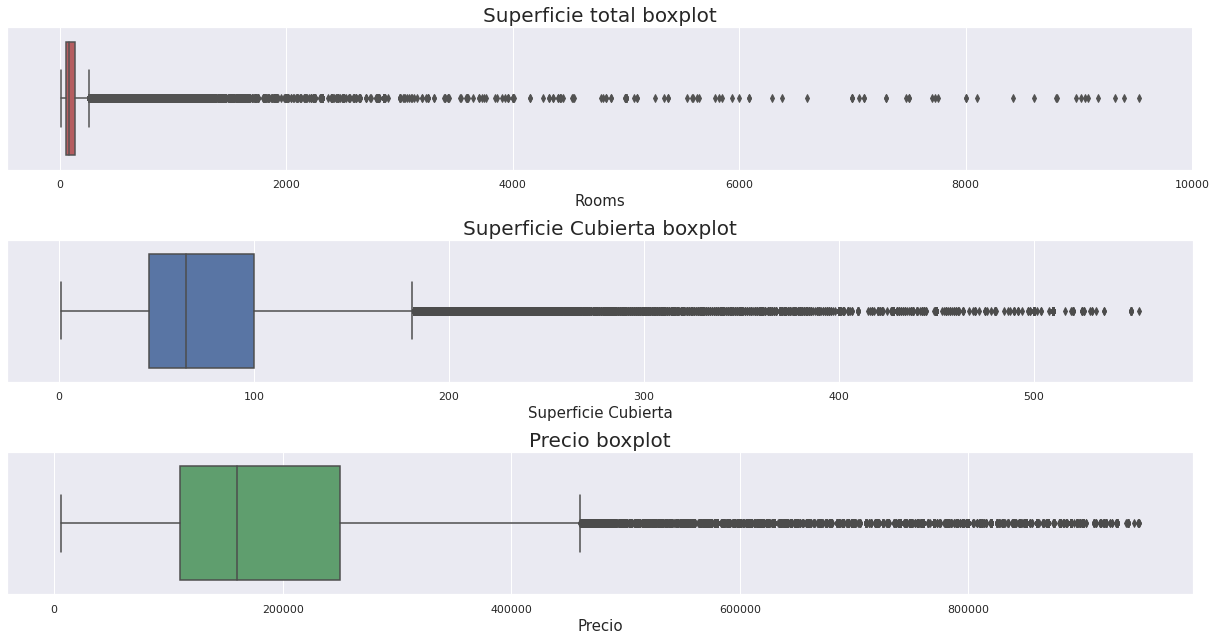

In [ ]:
plt.figure(figsize=(17,9))

plt.subplot(3,1,1)
plt.title('Superficie total boxplot', fontsize=20)
sns.boxplot(data=df, x='surface_total', color='r')
plt.xlabel('Rooms',fontsize=15)

plt.subplot(3,1,2)
plt.title('Superficie Cubierta boxplot', fontsize=20)
sns.boxplot(data=df, x='surface_covered', color='b')
plt.xlabel('Superficie Cubierta',fontsize=15)

plt.subplot(3,1,3)
plt.title('Precio boxplot', fontsize=20)
sns.boxplot(data=df, x='price', color='g')
plt.xlabel('Precio',fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
#Eliminación de outliers N2
lista = ['surface_total','surface_covered','price'] #Iteramos sobre cada una de las features
t=0 #Para acumular el total de instancias eliminadas por outliers
for i in lista:
  a=df.shape[0] #Cantidad de instancias inicial
  m=df[i].mean() #media
  std= df[i].std() #desviación estándar
  min= m - 3*std #mínimo
  max= m + 3*std #máximo
  df=df[(df[i]>min)&(df[i]<max)] #filtrado de exceso y defecto
  d=df.shape[0] #Cantidad de instancias finales
  e=a-d #total de filas eliminadas en iteración x
  t=t+e #total de filas eliminadas en todas las instancias
  print('Se eliminaron', e , 'instancias, debido a los outliers de la columna',i)
print('Se eliminaron un total de ',t,'instancias por los outliers de', lista)

Se eliminaron 1556 instancias, debido a los outliers de la columna surface_total
Se eliminaron 2691 instancias, debido a los outliers de la columna surface_covered
Se eliminaron 2965 instancias, debido a los outliers de la columna price
Se eliminaron un total de  7212 instancias por los outliers de ['surface_total', 'surface_covered', 'price']


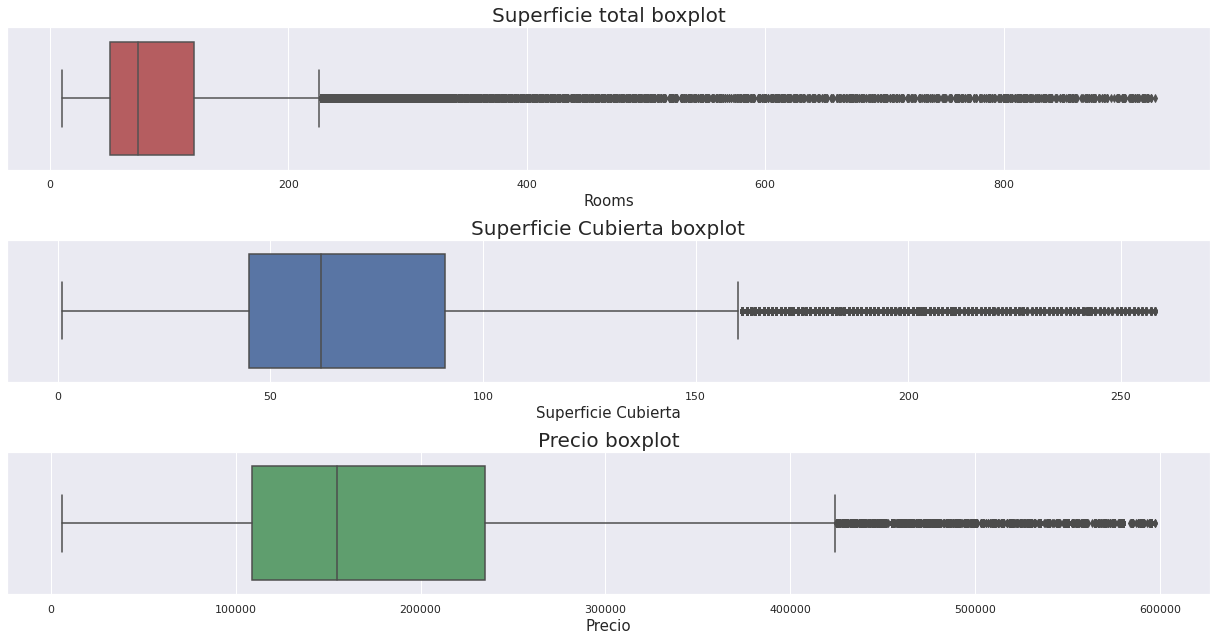

In [ ]:
plt.figure(figsize=(17,9))

plt.subplot(3,1,1)
plt.title('Superficie total boxplot', fontsize=20)
sns.boxplot(data=df, x='surface_total', color='r')
plt.xlabel('Rooms',fontsize=15)

plt.subplot(3,1,2)
plt.title('Superficie Cubierta boxplot', fontsize=20)
sns.boxplot(data=df, x='surface_covered', color='b')
plt.xlabel('Superficie Cubierta',fontsize=15)

plt.subplot(3,1,3)
plt.title('Precio boxplot', fontsize=20)
sns.boxplot(data=df, x='price', color='g')
plt.xlabel('Precio',fontsize=15)

plt.tight_layout()
plt.show()

In [ ]:
#Eliminación numero 3
'''lista = ['surface_total','surface_covered','price'] #Iteramos sobre cada una de las features
t=0 #Para acumular el total de instancias eliminadas por outliers
for i in lista:
  a=df.shape[0] #Cantidad de instancias inicial
  m=df[i].mean() #media
  std= df[i].std() #desviación estándar
  min= m - 3*std #mínimo
  max= m + 3*std #máximo
  df=df[(df[i]>min)&(df[i]<max)] #filtrado de exceso y defecto
  d=df.shape[0] #Cantidad de instancias finales
  e=a-d #total de filas eliminadas en iteración x
  t=t+e #total de filas eliminadas en todas las instancias
  print('Se eliminaron', e , 'instancias, debido a los outliers de la columna',i)
print('Se eliminaron un total de ',t,'instancias por los outliers de', lista)'''

"lista = ['surface_total','surface_covered','price'] #Iteramos sobre cada una de las features\nt=0 #Para acumular el total de instancias eliminadas por outliers\nfor i in lista:\n  a=df.shape[0] #Cantidad de instancias inicial\n  m=df[i].mean() #media\n  std= df[i].std() #desviación estándar\n  min= m - 3*std #mínimo\n  max= m + 3*std #máximo\n  df=df[(df[i]>min)&(df[i]<max)] #filtrado de exceso y defecto\n  d=df.shape[0] #Cantidad de instancias finales\n  e=a-d #total de filas eliminadas en iteración x\n  t=t+e #total de filas eliminadas en todas las instancias\n  print('Se eliminaron', e , 'instancias, debido a los outliers de la columna',i)\nprint('Se eliminaron un total de ',t,'instancias por los outliers de', lista)"

In [ ]:
'''plt.figure(figsize=(17,9))

plt.subplot(3,1,1)
plt.title('Superficie total boxplot', fontsize=20)
sns.boxplot(data=df, x='surface_total', color='r')
plt.xlabel('Rooms',fontsize=15)

plt.subplot(3,1,2)
plt.title('Superficie Cubierta boxplot', fontsize=20)
sns.boxplot(data=df, x='surface_covered', color='b')
plt.xlabel('Superficie Cubierta',fontsize=15)

plt.subplot(3,1,3)
plt.title('Precio boxplot', fontsize=20)
sns.boxplot(data=df, x='price', color='g')
plt.xlabel('Precio',fontsize=15)

plt.tight_layout()
plt.show() '''

"plt.figure(figsize=(17,9))\n\nplt.subplot(3,1,1)\nplt.title('Superficie total boxplot', fontsize=20)\nsns.boxplot(data=df, x='surface_total', color='r')\nplt.xlabel('Rooms',fontsize=15)\n\nplt.subplot(3,1,2)\nplt.title('Superficie Cubierta boxplot', fontsize=20)\nsns.boxplot(data=df, x='surface_covered', color='b')\nplt.xlabel('Superficie Cubierta',fontsize=15)\n\nplt.subplot(3,1,3)\nplt.title('Precio boxplot', fontsize=20)\nsns.boxplot(data=df, x='price', color='g')\nplt.xlabel('Precio',fontsize=15)\n\nplt.tight_layout()\nplt.show() "

Verificar si eliminar la primer tanda de OL ,las primeras dos o las primeras 3.

### **3- Latitud y Longitud**

In [ ]:
#Eliminación de outliers
lista = ['lat','lon'] #Iteramos sobre cada una de las features
t=0 #Para acumular el total de instancias eliminadas por outliers
for i in lista:
  a=df.shape[0] #Cantidad de instancias inicial
  m=df[i].mean() #media
  std= df[i].std() #desviación estándar
  min= m - 3*std #mínimo
  max= m + 3*std #máximo
  df=df[(df[i]>min)&(df[i]<max)] #filtrado de exceso y defecto
  d=df.shape[0] #Cantidad de instancias finales
  e=a-d #total de filas eliminadas en iteración x
  t=t+e #total de filas eliminadas en todas las instancias
  print('Se eliminaron', e , 'instancias, debido a los outliers de la columna',i)
print('Se eliminaron un total de ',t,'instancias por los outliers de', lista)

Se eliminaron 2 instancias, debido a los outliers de la columna lat
Se eliminaron 4524 instancias, debido a los outliers de la columna lon
Se eliminaron un total de  4526 instancias por los outliers de ['lat', 'lon']


## **V- Ingeniería de Features**

Vamos a crear alguna variables manualmente para ver si generan alguna mejora en el modelo

In [ ]:
df.shape

(121328, 11)

In [ ]:
df['espacios']= df['rooms']-df['bedrooms']
df['Area/habitación']=df['surface_covered']/df['rooms']

In [ ]:
df.head(3)

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,espacios,Area/habitación
0,-34.545990,-58.859357,Bs.As. G.B.A. Zona Norte,Pilar,1.0,1.0,1,50.0,35.0,45000.0,Departamento,0.0,35.0
2,-34.395413,-58.649914,Bs.As. G.B.A. Zona Norte,Tigre,2.0,1.0,2,99.0,84.0,215000.0,Departamento,1.0,42.0
3,-34.425087,-58.579659,Bs.As. G.B.A. Zona Norte,Tigre,2.0,1.0,1,50.0,50.0,109000.0,Departamento,1.0,25.0


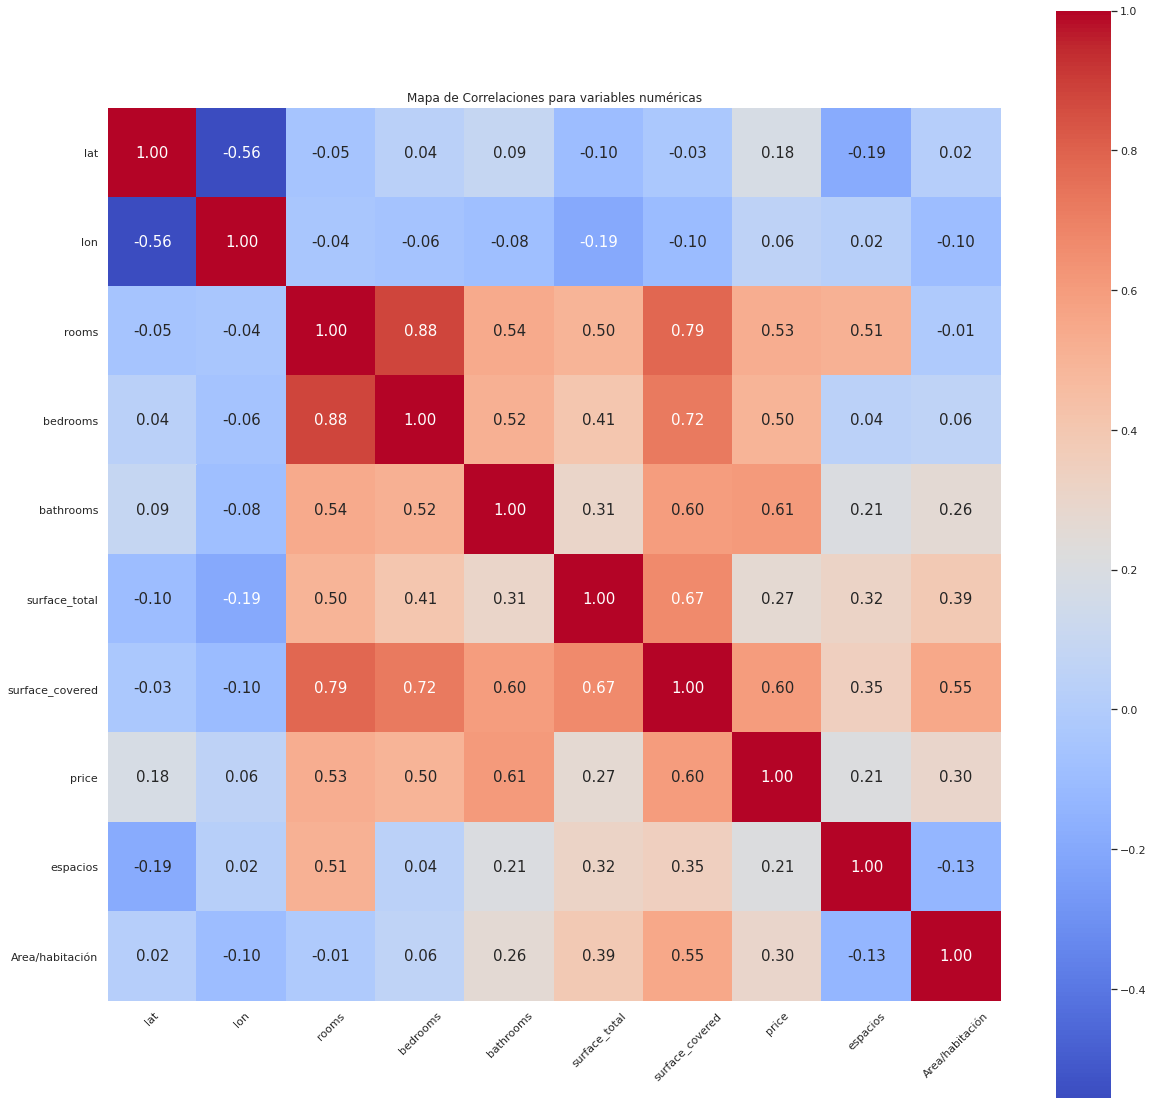

In [ ]:
#HeatMap de correlaciones para ver que que variables numéricas harían un buen KNN Imputer en Latitud, Longitud, Baños, Superficie Total y Superficie Cubierta.
corr= df.drop(['l2','l3','property_type'],axis=1).corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, 
            xticklabels= df.drop(['l2','l3','property_type'],axis=1).columns, 
            yticklabels= df.drop(['l2','l3','property_type'],axis=1).columns,
            cmap= 'coolwarm')
plt.title('Mapa de Correlaciones para variables numéricas')
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)
plt.show()

## **VI - Encoding**

Tenemos 3 atributos categóricos.

'l2', que representa la ciudad donde radica la propiedad.

'l3', que representa el barrio donde se encuentra la propiedad.

'property_type', que nos dice frente a que tipo de propiedad nos encontramos. 
Debido al filtro que hicimos en un primer momento, solo dejamos que existan tres tipos: Casas, PH y departamentos.

Ya que ninguna sigue alguna jerarquía en particular, podemos estar seguros de que estamos en frente de variables categóricas nominales.

In [ ]:
df.shape

(121328, 13)

In [ ]:
df = pd.get_dummies(df, columns=['property_type','l2'])
df.columns = ['lat','lon','l3','rooms','bedrooms','bathrooms','surface_total','surface_covered','price','espacios','Area/habitación','Casa','Departamento','PH','Zona_Norte','Zona_Oeste','Zona_Sur','Capital_Federal']
print(df.shape)
df.head()

(121328, 18)


,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,espacios,Area/habitación,Casa,Departamento,PH,Zona_Norte,Zona_Oeste,Zona_Sur,Capital_Federal
0,-34.545990,-58.859357,Pilar,1.0,1.0,1,50.0,35.0,45000.0,0.0,35.0,0,1,0,1,0,0,0
2,-34.395413,-58.649914,Tigre,2.0,1.0,2,99.0,84.0,215000.0,1.0,42.0,0,1,0,1,0,0,0
3,-34.425087,-58.579659,Tigre,2.0,1.0,1,50.0,50.0,109000.0,1.0,25.0,0,1,0,1,0,0,0
4,-34.465059,-58.639224,Tigre,2.0,1.0,1,53.0,42.0,145000.0,1.0,21.0,0,1,0,1,0,0,0
5,-34.422972,-58.573448,Tigre,2.0,1.0,1,70.0,57.0,135000.0,1.0,28.5,0,1,0,1,0,0,0


In [ ]:
df = pd.get_dummies(data=df, prefix='barrio',columns=['l3'])
print(df.shape)
df.head()

(121328, 105)


,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,espacios,Area/habitación,Casa,Departamento,PH,Zona_Norte,Zona_Oeste,Zona_Sur,Capital_Federal,barrio_Abasto,barrio_Agronomía,barrio_Almagro,barrio_Almirante Brown,barrio_Avellaneda,barrio_Balvanera,barrio_Barracas,barrio_Barrio Norte,barrio_Belgrano,barrio_Berazategui,barrio_Boca,barrio_Boedo,barrio_Caballito,barrio_Catalinas,barrio_Cañuelas,barrio_Centro / Microcentro,barrio_Chacarita,barrio_Coghlan,barrio_Colegiales,barrio_Congreso,barrio_Constitución,barrio_Escobar,barrio_Esteban Echeverría,...,barrio_Parque Avellaneda,barrio_Parque Centenario,barrio_Parque Chacabuco,barrio_Parque Chas,barrio_Parque Patricios,barrio_Paternal,barrio_Pilar,barrio_Pompeya,barrio_Presidente Perón,barrio_Puerto Madero,barrio_Quilmes,barrio_Recoleta,barrio_Retiro,barrio_Saavedra,barrio_San Cristobal,barrio_San Fernando,barrio_San Isidro,barrio_San Miguel,barrio_San Nicolás,barrio_San Telmo,barrio_San Vicente,barrio_Tigre,barrio_Tres de Febrero,barrio_Tribunales,barrio_Velez Sarsfield,barrio_Versalles,barrio_Vicente López,barrio_Villa Crespo,barrio_Villa Devoto,barrio_Villa General Mitre,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortuzar,barrio_Villa Pueyrredón,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque
0,-34.545990,-58.859357,1.0,1.0,1,50.0,35.0,45000.0,0.0,35.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-34.395413,-58.649914,2.0,1.0,2,99.0,84.0,215000.0,1.0,42.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-34.425087,-58.579659,2.0,1.0,1,50.0,50.0,109000.0,1.0,25.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-34.465059,-58.639224,2.0,1.0,1,53.0,42.0,145000.0,1.0,21.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,-34.422972,-58.573448,2.0,1.0,1,70.0,57.0,135000.0,1.0,28.5,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **VII - Escalado de Datos / Normalización**

### Escalado

Voy a aplicar Standard Scaler a todas las siguientes variables numéricas: 



*   `'rooms', 'bedrooms', 'bathrooms','espacios'` - Variables discretas
*   `'lat', 'lon', 'surface_total','surface_covered', , 'Area/habitación'` - Variables continuas






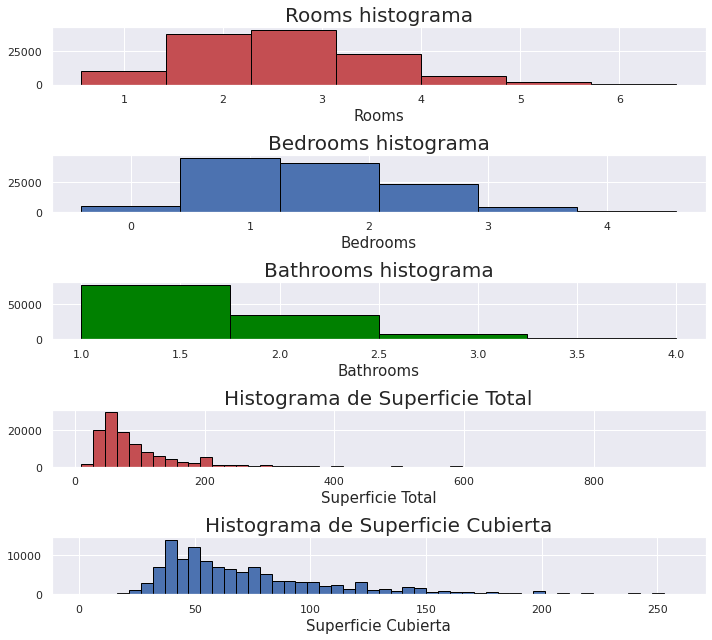

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,9))

plt.subplot(5,1,1)
plt.title('Rooms histograma', fontsize=20)
df.rooms.hist(label = 'rooms', color='r',bins=7,align='left',edgecolor='black')
plt.xlabel('Rooms',fontsize=15)

plt.subplot(5,1,2)
plt.title('Bedrooms histograma', fontsize=20)
df.bedrooms.hist(label = 'rooms', color='b',bins=6,align='left',edgecolor='black')
plt.xlabel('Bedrooms',fontsize=15)

plt.subplot(5,1,3)
plt.title('Bathrooms histograma', fontsize=20)
df.bathrooms.hist(label = 'rooms', color='green',bins=4,align='mid',edgecolor='black')
plt.xlabel('Bathrooms',fontsize=15)

plt.subplot(5,1,4)
plt.title('Histograma de Superficie Total', fontsize=20)
df.surface_total.hist(label = 'surface_total', color='r',bins=50,align='mid',edgecolor='black')
plt.xlabel('Superficie Total',fontsize=15)

plt.subplot(5,1,5)
plt.title('Histograma de Superficie Cubierta', fontsize=20)
df.surface_covered.hist(label = 'surface_covered', color='b',bins=50,align='mid',edgecolor='black')
plt.xlabel('Superficie Cubierta',fontsize=15)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

En la figura de arriba, podemos ver la distribución original de las variables

In [ ]:
X = df.drop(['price'],axis=1)
y= df.price

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(84929, 104) (84929,) (36399, 104) (36399,)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()

In [ ]:
columnas = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
            'surface_covered', 'espacios', 'Area/habitación']

In [ ]:
for columna in columnas:
  X_train[[columna]] = scaler.fit_transform(X_train[[columna]])
  X_test[[columna]] = scaler.fit_transform(X_test[[columna]])

round(X_train.describe(),2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,espacios,Area/habitación,Casa,Departamento,PH,Zona_Norte,Zona_Oeste,Zona_Sur,Capital_Federal,barrio_Abasto,barrio_Agronomía,barrio_Almagro,barrio_Almirante Brown,barrio_Avellaneda,barrio_Balvanera,barrio_Barracas,barrio_Barrio Norte,barrio_Belgrano,barrio_Berazategui,barrio_Boca,barrio_Boedo,barrio_Caballito,barrio_Catalinas,barrio_Cañuelas,barrio_Centro / Microcentro,barrio_Chacarita,barrio_Coghlan,barrio_Colegiales,barrio_Congreso,barrio_Constitución,barrio_Escobar,barrio_Esteban Echeverría,barrio_Ezeiza,...,barrio_Parque Avellaneda,barrio_Parque Centenario,barrio_Parque Chacabuco,barrio_Parque Chas,barrio_Parque Patricios,barrio_Paternal,barrio_Pilar,barrio_Pompeya,barrio_Presidente Perón,barrio_Puerto Madero,barrio_Quilmes,barrio_Recoleta,barrio_Retiro,barrio_Saavedra,barrio_San Cristobal,barrio_San Fernando,barrio_San Isidro,barrio_San Miguel,barrio_San Nicolás,barrio_San Telmo,barrio_San Vicente,barrio_Tigre,barrio_Tres de Febrero,barrio_Tribunales,barrio_Velez Sarsfield,barrio_Versalles,barrio_Vicente López,barrio_Villa Crespo,barrio_Villa Devoto,barrio_Villa General Mitre,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortuzar,barrio_Villa Pueyrredón,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque
count,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,...,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00,84929.00
mean,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.11,0.78,0.11,0.16,0.09,0.08,0.67,0.00,0.00,0.06,0.01,0.01,0.02,0.01,0.02,0.05,0.00,0.00,0.01,0.05,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.00,...,0.00,0.01,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.04,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.00,0.06,0.02,0.00,0.00,0.00,0.02,0.05,0.01,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.03,0.01
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.31,0.41,0.31,0.36,0.28,0.28,0.47,0.06,0.04,0.24,0.08,0.10,0.15,0.08,0.15,0.21,0.07,0.05,0.08,0.22,0.01,0.02,0.06,0.08,0.07,0.11,0.07,0.06,0.09,0.06,0.06,...,0.04,0.10,0.08,0.05,0.06,0.09,0.12,0.04,0.02,0.07,0.11,0.19,0.07,0.09,0.11,0.08,0.12,0.10,0.08,0.09,0.03,0.24,0.15,0.04,0.04,0.04,0.15,0.22,0.10,0.06,0.06,0.09,0.05,0.07,0.03,0.02,0.05,0.02,0.16,0.10
min,-5.98,-3.96,-1.68,-1.92,-0.67,-0.93,-1.79,-9.70,-3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.33,-0.33,-0.77,-0.87,-0.67,-0.55,-0.71,-0.06,-0.71,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-0.04,0.29,0.13,0.18,-0.67,-0.32,-0.33,-0.06,-0.18,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0

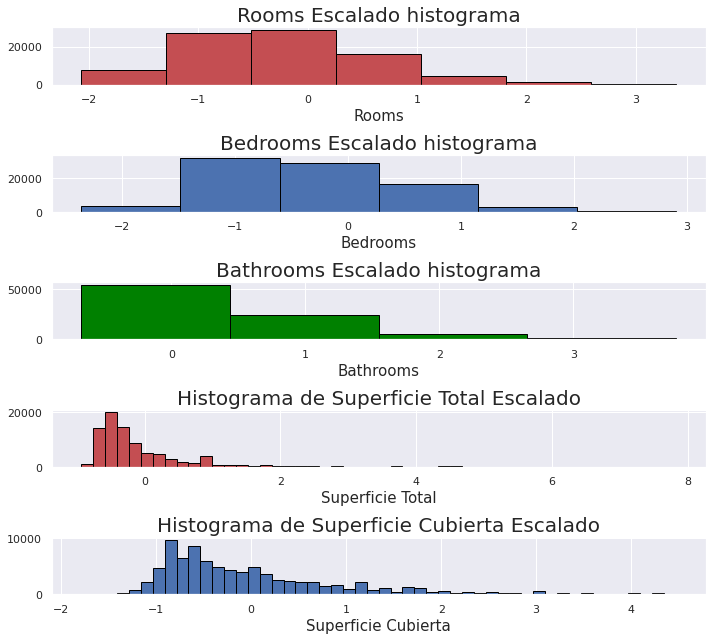

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,9))

plt.subplot(5,1,1)
plt.title('Rooms Escalado histograma', fontsize=20)
X_train.rooms.hist(label = 'rooms', color='r',bins=7,align='left',edgecolor='black')
plt.xlabel('Rooms',fontsize=15)

plt.subplot(5,1,2)
plt.title('Bedrooms Escalado histograma', fontsize=20)
X_train.bedrooms.hist(label = 'rooms', color='b',bins=6,align='left',edgecolor='black')
plt.xlabel('Bedrooms',fontsize=15)

plt.subplot(5,1,3)
plt.title('Bathrooms Escalado histograma', fontsize=20)
X_train.bathrooms.hist(label = 'rooms', color='green',bins=4,align='mid',edgecolor='black')
plt.xlabel('Bathrooms',fontsize=15)

plt.subplot(5,1,4)
plt.title('Histograma de Superficie Total Escalado', fontsize=20)
X_train.surface_total.hist(label = 'surface_total', color='r',bins=50,align='mid',edgecolor='black')
plt.xlabel('Superficie Total',fontsize=15)

plt.subplot(5,1,5)
plt.title('Histograma de Superficie Cubierta Escalado', fontsize=20)
X_train.surface_covered.hist(label = 'surface_covered', color='b',bins=50,align='mid',edgecolor='black')
plt.xlabel('Superficie Cubierta',fontsize=15)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

Así es como quedan los histogramas de las variables mencionadas, después de una transformación mediante un Standard Scaler

## **VIII- Principal Component Analysis**

Para la reducción de dimensionalidad voy a utilizar la técnica del PCA

In [ ]:
X_train.head()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,espacios,Area/habitación,Casa,Departamento,PH,Zona_Norte,Zona_Oeste,Zona_Sur,Capital_Federal,barrio_Abasto,barrio_Agronomía,barrio_Almagro,barrio_Almirante Brown,barrio_Avellaneda,barrio_Balvanera,barrio_Barracas,barrio_Barrio Norte,barrio_Belgrano,barrio_Berazategui,barrio_Boca,barrio_Boedo,barrio_Caballito,barrio_Catalinas,barrio_Cañuelas,barrio_Centro / Microcentro,barrio_Chacarita,barrio_Coghlan,barrio_Colegiales,barrio_Congreso,barrio_Constitución,barrio_Escobar,barrio_Esteban Echeverría,barrio_Ezeiza,...,barrio_Parque Avellaneda,barrio_Parque Centenario,barrio_Parque Chacabuco,barrio_Parque Chas,barrio_Parque Patricios,barrio_Paternal,barrio_Pilar,barrio_Pompeya,barrio_Presidente Perón,barrio_Puerto Madero,barrio_Quilmes,barrio_Recoleta,barrio_Retiro,barrio_Saavedra,barrio_San Cristobal,barrio_San Fernando,barrio_San Isidro,barrio_San Miguel,barrio_San Nicolás,barrio_San Telmo,barrio_San Vicente,barrio_Tigre,barrio_Tres de Febrero,barrio_Tribunales,barrio_Velez Sarsfield,barrio_Versalles,barrio_Vicente López,barrio_Villa Crespo,barrio_Villa Devoto,barrio_Villa General Mitre,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortuzar,barrio_Villa Pueyrredón,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque
38338,-2.832904,2.897715,0.131118,0.183530,0.807199,-0.191965,0.307567,-0.056988,0.337199,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16857,0.851951,-0.008724,0.131118,0.183530,0.807199,-0.163238,0.380607,-0.056988,0.453002,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
121607,-0.172985,0.294669,1.037201,1.236708,0.807199,-0.124935,0.477993,-0.056988,-0.299714,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
75194,0.208743,0.170370,-0.774964,-0.869648,-0.672695,-0.450509,-0.495870,-0.056988,0.105594,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51263,-0.376608,0.847017,1.037201,1.236708,-0.672695,-0.268570,-0.008938,-0.056988,-0.878727,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_PCA_train = X_train.copy() 
X_PCA_test = X_test.copy() 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10,random_state=42)

In [ ]:
X_PCA_train= pca.fit_transform(X_PCA_train)
X_PCA_test= pca.transform(X_PCA_test)

In [ ]:
X_PCA_train.shape, X_PCA_test.shape

((84929, 10), (36399, 10))

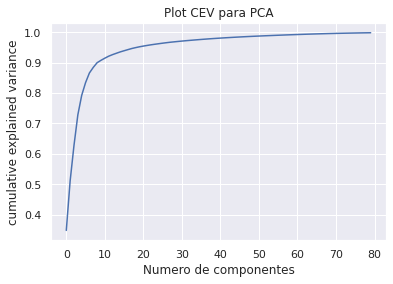

In [ ]:
pca = PCA(80).fit(X_test)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Plot CEV para PCA")
plt.xlabel('Numero de componentes')
plt.ylabel('cumulative explained variance');

Ya que el punto cerca de x = 10 la función comienza a ser asintótica, podríamos tomar n_componentes = 10, y estaríamos abarcando un poco mas del 90%. De querer algo más cercano al 100% podriamos agarrar componentes del orden de los 65 en adelante.

## **IX - Fin Parte A: Reentreno del mejor modelo del Proyecto 1**

### **Funciones que utilizaremos**

In [ ]:
def evaluacion_modelo(modelo,X_train,X_test,y_train,y_test):

#Esta función sirve para, dado X modelo que ya se ajustaron los datos de 
#entrenamiento X_train mediante el método modelo.fit(X_trian,y_train), 
#devuelve las métricas de RMSE / R^2 / R^2*ajustado. A su vez, para cada métrica,
#devuelve la variación entre el conjunto de train y test.

  %%time
  from sklearn.metrics import r2_score
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error


  y_train_pred = modelo.predict(X_train)
  y_test_pred = modelo.predict(X_test)

  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
  print("------ --------  --------")
  print(f'Raíz del error cuadrático medio en Train: ', round(rmse_train,4))
  print(f'Raíz del error cuadrático medio en Test:', round(rmse_test,4))
  print('La variación de esta métrica es igual a',np.abs(rmse_train-rmse_test))
  print("------ --------  --------")

  r2_train = r2_score(y_train, y_train_pred)
  r2_test = r2_score(y_test, y_test_pred)
  print("La calidad del modelo en el conjunto de Train", round(r2_train, 3)*100, '%')
  print("La calidad del modelo en el conjunto de Test:", round(r2_test, 3)*100, '%')
  print('La variación de esta métrica es igual a',np.abs(r2_train-r2_test)*100,'%')
  print("------ --------  --------")

  r2a_train= adjustedR2(r2_train,X_train.shape[0], X_train.shape[1])
  r2a_test= adjustedR2(r2_test,X_test.shape[0], X_test.shape[1])
  print('El R cuadrado ajustado para el Train es', round( r2a_train,3)*100, '%')
  print('El R cuadrado ajustado para el Test es', round(r2a_test,3)*100, '%')
  print('La variación de esta métrica es igual a',np.abs(r2_train-r2_test)*100,'%')
  plt.figure(figsize = (14,4))
   
  ax = plt.subplot(1,2,1)
  ax.scatter(y_test,y_test_pred, s =2,color='brown')
    
  lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
        ]
    
  ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,linewidth= 3)
  plt.title('Predicción vs. Real')
  plt.xlabel('y (test)')
  plt.ylabel('y_pred (test)')

  plt.subplot(1,2,2)  
  sns.distplot(y_train - y_train_pred, bins = 20, label = 'train',color='blue')
  sns.distplot(y_test - y_test_pred, bins = 20, label = 'test',color='red')
  plt.title('Distribucón del Error')
  plt.xlabel('errores')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
def reduce_mem_usage(df, verbose=True):

 #Función para reducir el almacenamiento usado por un dataframe
 #mediante la reducción de sus dtypes al mínimo admisible por la característica
 # de su columna

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
#Métrica para hallar el R^2 ajustado:
# Siendo n = número de muestras y k = cantidad de parámetros
def adjustedR2(r2,n,k):
    return 1- (((n-1)/(n-k-1))*(1-r2))

### **Modelo con Dataset preprocesado sin PCA**

Modelo anterior:

`DecisionTreeRegressor ( max_depth = 12 , random_state= 42)`

Métricas:

1.   RMSE Train: 102167.545
2.   RMSE Test: 149019.198


3.   R cuadrado Train: 0.882 = 82,2%
4.   R cuadrado Test: 0.757 = 75,7%


5.   R cuadrado ajustado Train: 0.882 = 82,2%
6.   R cuadrado ajustado : 0.757 = 75,7%




Ahora, entrenaré el modelo del proyecto 1 con este nuesvo dataset transformado.

En la evaluacion del modelo del proyecto 1 utilicé 3 metricas: **RMSE, Rcuadrado y Rcuadrado ajustado.**

In [ ]:
print(X_train.shape,X_test.shape,X_PCA_train.shape ,X_PCA_test.shape ,y_train.shape, y_test.shape)

(84929, 104) (36399, 104) (84929, 10) (36399, 10) (84929,) (36399,)


In [ ]:
reduce_mem_usage(X_train)
reduce_mem_usage(X_test)


Memory usage after optimization is: 9.80 MB
Decreased by 30.9%
Memory usage after optimization is: 4.20 MB
Decreased by 30.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,espacios,Area/habitación,Casa,Departamento,PH,Zona_Norte,Zona_Oeste,Zona_Sur,Capital_Federal,barrio_Abasto,barrio_Agronomía,barrio_Almagro,barrio_Almirante Brown,barrio_Avellaneda,barrio_Balvanera,barrio_Barracas,barrio_Barrio Norte,barrio_Belgrano,barrio_Berazategui,barrio_Boca,barrio_Boedo,barrio_Caballito,barrio_Catalinas,barrio_Cañuelas,barrio_Centro / Microcentro,barrio_Chacarita,barrio_Coghlan,barrio_Colegiales,barrio_Congreso,barrio_Constitución,barrio_Escobar,barrio_Esteban Echeverría,barrio_Ezeiza,...,barrio_Parque Avellaneda,barrio_Parque Centenario,barrio_Parque Chacabuco,barrio_Parque Chas,barrio_Parque Patricios,barrio_Paternal,barrio_Pilar,barrio_Pompeya,barrio_Presidente Perón,barrio_Puerto Madero,barrio_Quilmes,barrio_Recoleta,barrio_Retiro,barrio_Saavedra,barrio_San Cristobal,barrio_San Fernando,barrio_San Isidro,barrio_San Miguel,barrio_San Nicolás,barrio_San Telmo,barrio_San Vicente,barrio_Tigre,barrio_Tres de Febrero,barrio_Tribunales,barrio_Velez Sarsfield,barrio_Versalles,barrio_Vicente López,barrio_Villa Crespo,barrio_Villa Devoto,barrio_Villa General Mitre,barrio_Villa Lugano,barrio_Villa Luro,barrio_Villa Ortuzar,barrio_Villa Pueyrredón,barrio_Villa Real,barrio_Villa Riachuelo,barrio_Villa Santa Rita,barrio_Villa Soldati,barrio_Villa Urquiza,barrio_Villa del Parque
132471,0.118347,0.722656,-1.688477,-0.871094,-0.673828,-0.803711,-1.257812,-1.971680,-0.350098,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111817,0.005878,0.288818,-0.784180,-0.871094,-0.673828,-0.623535,-0.843750,-0.069031,-0.695312,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
100054,-0.113159,0.452393,-0.784180,-0.871094,-0.673828,-0.595215,-0.794922,-0.069031,-0.580566,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
86498,-0.173218,0.807617,0.120056,0.177246,-0.673828,-0.557129,-0.672852,-0.069031,-1.194336,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4928,2.402344,-1.750000,0.120056,0.177246,0.806152,0.561523,0.253662,-0.069031,0.263916,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68661,-0.178589,0.705566,-0.784180,-0.871094,-0.673828,-0.689941,-0.965332,-0.069031,-0.983398,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
102590,-0.290771,0.108459,1.928711,1.225586,2.287109,0.182373,1.058594,1.833984,-0.281006,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89652,0.377197,0.350098,1.024414,1.225586,0.806152,0.258301,1.131836,-0.069031,0.484619,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
76788,-0.054565,0.582520,0.120056,0.177246,-0.673828,-0.339111,-0.063293,-0.069031,-0.234985,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Siendo n = número de muestras y k = cantidad de parámetros
def adjustedR2(r2,n,k):
    return 1- (((n-1)/(n-k-1))*(1-r2))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  43274.4195
Raíz del error cuadrático medio en Test: 51013.0087
La variación de esta métrica es igual a 7738.58919324787
------ --------  --------
La calidad del modelo en el conjunto de Train 83.39999999999999 %
La calidad del modelo en el conjunto de Test: 77.0 %
La variación de esta métrica es igual a 6.412966715234603 %
------ --------  --------
El R cuadrado ajustado para el Train es 83.39999999999999 %
El R cuadrado ajustado para el Test es 77.0 %
La variación de esta métrica es igual a 6.412966715234603 %


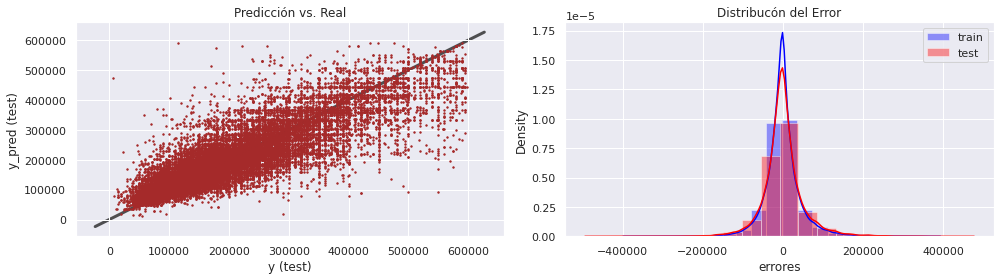

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_regressor = DecisionTreeRegressor(max_depth=12, random_state=42)

tree_regressor.fit(X_train, y_train)

evaluacion_modelo(tree_regressor,X_train,X_test,y_train,y_test)

In [ ]:
from sklearn.model_selection import cross_validate

results = cross_validate(tree_regressor, X_train, y_train, cv=5, return_train_score=True, scoring='r2', n_jobs=-1)
print('Mean r2 test: ', np.mean(results['test_score']))

Mean r2 test:  0.7713768245422363


Metricas nuevas:

1.   RMSE Train:     **43.235,37**    >     102.167,54
2.   RMSE Test:      **51.207,79**    >     149.019,19


---


---





3.   R cuadrado Train:   **83.5 %**   >     82,2%
4.   R cuadrado Test:    **76.8 %**   >     75,7%



---



---


5.   R cuadrado ajustado Train: **83.5 %** > 82,2%
6.   R cuadrado ajustado Test:  **76.8 %** > 75,7%



Vemos que el RMSE en el conjunto de Test disminuye **97.812 U$D**, es decir mejoró un **65,63%**(este porcentaje equivale a : disminución/total anterior = 97.812/149.019) respecto al modelo anterior (basandome únicamente en esta métrica), todo gracias al preprocesamiento.

 A su vez, la variación para esta métrica entre los conjuntos train y test era de 23.426 en el modelo anterior. Ahora, la variación es de 3.986


Vamos a guardar las métricas de este modelo para usarlo como benchmark

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
Benchmark = {
    'Modelo':'Arbol P01 Benchmark',
    'RMSE Train':rmse_train,
    'R2 Train':r2_train,
    'RMSE Test':rmse_test,
    'R2 Test':r2_test   
}

In [ ]:
print(Benchmark)

{'Modelo': 'Arbol P01 Benchmark', 'RMSE Train': 43274.419497872244, 'R2 Train': 0.8343813017856173, 'RMSE Test': 51013.008691120114, 'R2 Test': 0.7702516346332713}


### **Modelo con Dataset preprocesado con PCA**

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  45528.6358
Raíz del error cuadrático medio en Test: 56782.1136
La variación de esta métrica es igual a 11253.477716014808
------ --------  --------
La calidad del modelo en el conjunto de Train 81.69999999999999 %
La calidad del modelo en el conjunto de Test: 71.5 %
La variación de esta métrica es igual a 10.132896465220753 %
------ --------  --------
El R cuadrado ajustado para el Train es 81.69999999999999 %
El R cuadrado ajustado para el Test es 71.5 %
La variación de esta métrica es igual a 10.132896465220753 %


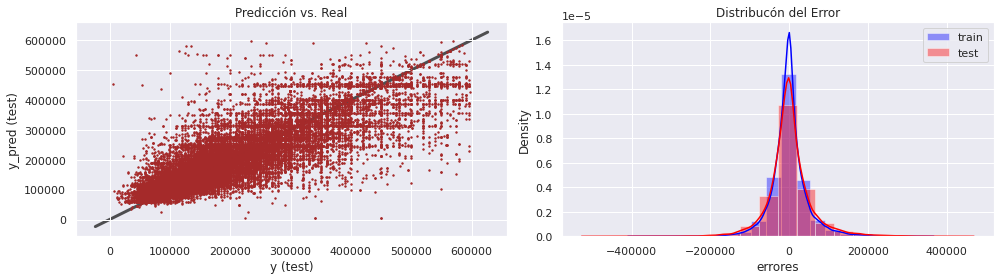

In [ ]:
tree_regressor = DecisionTreeRegressor(max_depth=12, random_state=42)

tree_regressor.fit(X_PCA_train, y_train)

evaluacion_modelo(tree_regressor,X_PCA_train,X_PCA_test,y_train,y_test)

Metricas nuevas con PCA:

1.   RMSE Train:     **45.528.63,37**    >     102.167,54
2.   RMSE Test:      **56.782.11**    >     149.019,19


---


---





3.   R cuadrado Train:   **81.69 %**   <     82,2%
4.   R cuadrado Test:    **71.5 %**    <    75,7%



---



---


5.   R cuadrado ajustado Train: **81.69 %**  > 82,2%
6.   R cuadrado ajustado Test:  **71.5 %** > 75,7%



Vemos que el RMSE en el conjunto de Test disminuye 92.237 U$D, es decir mejoró un 61,89% respecto al modelo anterior (basandome únicamente en esta métrica).
Disminuyó el performance del modelo debido a que cuando hicimos la reducción de la dimensionalidad, nos quedamos con los n-componentes que explicaban el 90% de la varianza


Respecto a las otras métricas, no hubo una disminución del R, bajando casi 4 puntos porcentuales en el conjunto de test.

# **Parte B**

### Intro

**BENCHMARK :**



1.   **RMSE Test : 51.013,008**
2.   **R2 Test: 77.0 %**



Vamos a analizar 3 modelos:

1.   Arbol de Decisión (igual al Benchmark) pero con Optimización de hiperparámetros
2.   Regresión Lineal con atributos polinómicos y regularización
3.   Random Forest
4.   XGBoost



In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

## **1- Arbol de Decisión**


### **Grid Search para arbol de decisión**

In [ ]:
#from sklearn.model_selection import GridSearchCV

#tree_regressor = DecisionTreeRegressor(max_depth=12, random_state=42)
#tree_regressor.fit(X_train, y_train)

# Hiper parámetros de la grida
#grida= {
#    'max_depth': [13,16],
#    'criterion':['mse','friedman_mse','mae'],
#    'min_samples_split': [1.0,2,3],
#    'min_samples_leaf': [1,5,10],
#    'splitter':['best','random']
#    }

#grid = GridSearchCV(estimator=tree_regressor, param_grid=grida,
#                    scoring='r2', cv=4)

#grid.fit(X_train, y_train)
#print(grid.best_score_)
#print(grid.best_estimator_)
#print(grid.best_params_)

### **Arbol de decisión optimizado**

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  34738.3461
Raíz del error cuadrático medio en Test: 49032.7898
La variación de esta métrica es igual a 14294.44366349333
------ --------  --------
La calidad del modelo en el conjunto de Train 89.3 %
La calidad del modelo en el conjunto de Test: 78.8 %
La variación de esta métrica es igual a 10.553310101706204 %
------ --------  --------
El R cuadrado ajustado para el Train es 89.3 %
El R cuadrado ajustado para el Test es 78.7 %
La variación de esta métrica es igual a 10.553310101706204 %


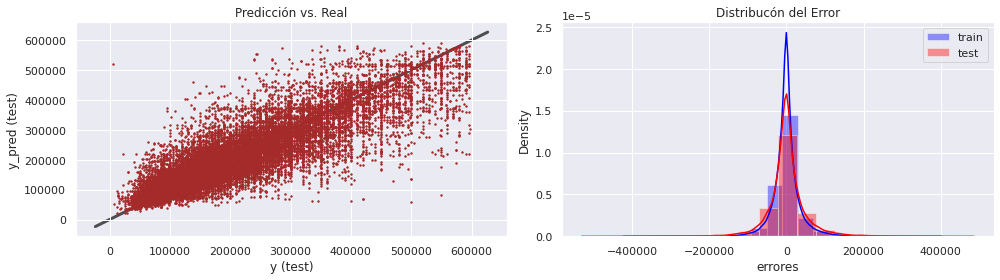

In [ ]:
tree_regressor = DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=16,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

tree_regressor.fit(X_train, y_train)

evaluacion_modelo(tree_regressor,X_train,X_test,y_train,y_test)

### **Cross Validation para Arbol Optimizado**

In [ ]:
C

In [ ]:
y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

Vamos a guardar las métricas de este modelo para comparar más tarde

In [ ]:
Arbol_O = {
    'Modelo':'Arbol Optimizado',
    'RMSE Train':rmse_train,
    'R2 Train':r2_train,
    'RMSE Test':rmse_test,
    'R2 Test':r2_test   
}

## **2-Regresión lineal con atributos polinómicos y regularización**

### **Regresión Lineal simple**

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 10.3 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  67351.2929
Raíz del error cuadrático medio en Test: 67318.1586
La variación de esta métrica es igual a 33.134363710007165
------ --------  --------
La calidad del modelo en el conjunto de Train 59.9 %
La calidad del modelo en el conjunto de Test: 60.0 %
La variación de esta métrica es igual a 0.10919826732906923 %
------ --------  --------
El R cuadrado ajustado para el Train es 59.9 %
El R cuadrado ajustado para el Test es 60.0 %
La variación de esta métrica es igual a 0.10919826732906923 %


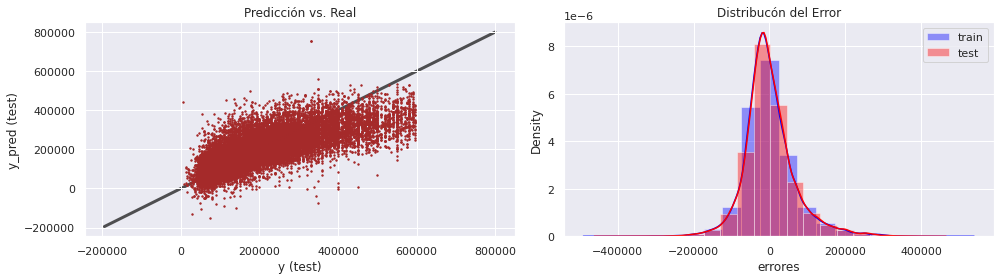

In [ ]:
reg = LinearRegression()

reg.fit(X_PCA_train, y_train)

evaluacion_modelo(reg,X_PCA_train,X_PCA_test,y_train,y_test)

### **Regresión lineal con atributos polinómicos**

Parte de la estrategia de agregar atributs polinómicos, será trabajar con los conjuntos preprocesados con reducción de dimensionalidad PCA, **X_PCA_train y X_PCA_test** debido a que son conjuntos muy ligeros en comparación del **X_train y X_test**

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 1
Agregamos atributos hasta la potencia x**1
CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 11.9 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  67351.2929
Raíz del error cuadrático medio en Test: 67318.1586
La variación de esta métrica es igual a 17
------ --------  --------
La calidad del modelo en el conjunto de Train 59.9 %
La calidad del modelo en el conjunto de Test: 60.0 %
La variación de esta métrica es igual a 0.05 %
------ --------  --------
El R cuadrado ajustado para el Train es 59.9 %
El R cuadrado ajustado para el Test es 60.0 %
La variación de esta métrica es igual a 0.05 %


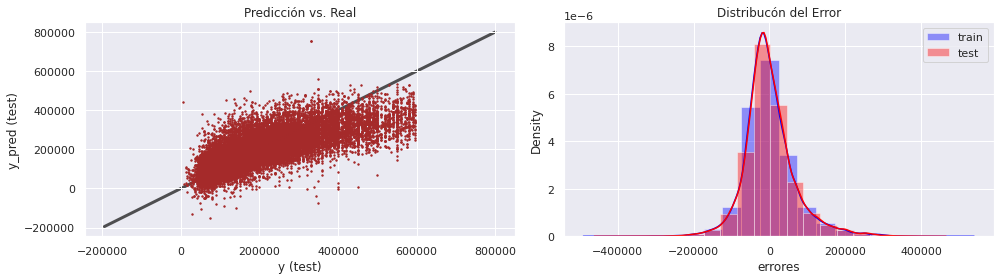

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 2
Agregamos atributos hasta la potencia x**2
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  59326.3983
Raíz del error cuadrático medio en Test: 59488.7249
La variación de esta métrica es igual a 81
------ --------  --------
La calidad del modelo en el conjunto de Train 68.89999999999999 %
La calidad del modelo en el conjunto de Test: 68.8 %
La variación de esta métrica es igual a 0.06 %
------ --------  --------
El R cuadrado ajustado para el Train es 68.8 %
El R cuadrado ajustado para el Test es 68.7 %
La variación de esta métrica es igual a 0.07 %


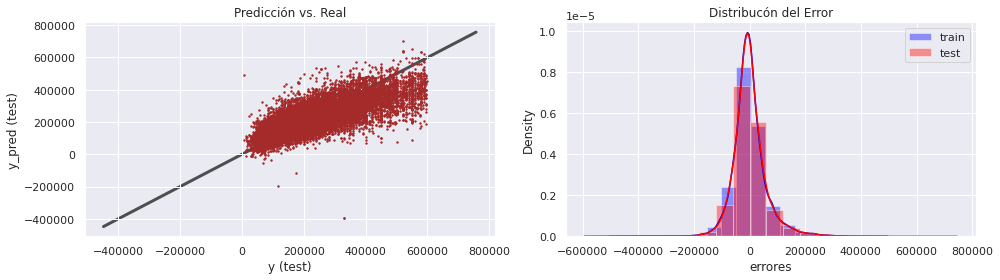

REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO 3
Agregamos atributos hasta la potencia x**3
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  55593.726
Raíz del error cuadrático medio en Test: 56005.7212
La variación de esta métrica es igual a 206
------ --------  --------
La calidad del modelo en el conjunto de Train 72.7 %
La calidad del modelo en el conjunto de Test: 72.3 %
La variación de esta métrica es igual a 0.18 %
------ --------  --------
El R cuadrado ajustado para el Train es 72.6 %
El R cuadrado ajustado para el Test es 72.1 %
La variación de esta métrica es igual a 0.24 %


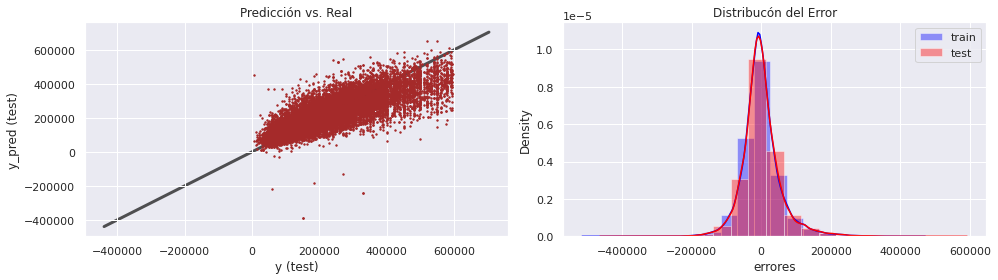

In [ ]:
for idx,potencia_maxima in enumerate(range(1,4)):

  print(f'REGRESIÓN CON ATRIBUTOS POLINÓMICOS NUMERO {idx + 1}')
  print(f'Agregamos atributos hasta la potencia x**{potencia_maxima}')

  poly = PolynomialFeatures(degree = potencia_maxima, include_bias=False)  
  X_train1 = poly.fit_transform(X_PCA_train)
  X_test1= poly.fit_transform(X_PCA_test)


  ### ENTRENAMOS
  reg = LinearRegression()
  reg.fit(X_train1, y_train)
    
    
  ### COMPLETAR AQUI PARA RESOLVER CHALLENGE
  #print(f'Pendientes: {reg.coef_}')
  #print(f'Ordenada: {reg.intercept_}')
    
  evaluacion_modelo(reg,X_train1,X_test1,y_train,y_test)

Según lo que vemos en el código de arriba, las métricas mejoran en gran manera para atributos a la potencia X^2, y la última mejora se da para X^3, por lo que nos quedaremos con un PolynomialFeatures

Lamentablemente, antes de poder imprimir métricas de X^6 la ejecucón colapsa debido a la RAM, por lo que nuestro análisis termina para X^5

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.06 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  55593.726
Raíz del error cuadrático medio en Test: 56005.7212
La variación de esta métrica es igual a 411.99524002657563
------ --------  --------
La calidad del modelo en el conjunto de Train 72.7 %
La calidad del modelo en el conjunto de Test: 72.3 %
La variación de esta métrica es igual a 0.358364587842841 %
------ --------  --------
El R cuadrado ajustado para el Train es 72.6 %
El R cuadrado ajustado para el Test es 72.1 %
La variación de esta métrica es igual a 0.358364587842841 %


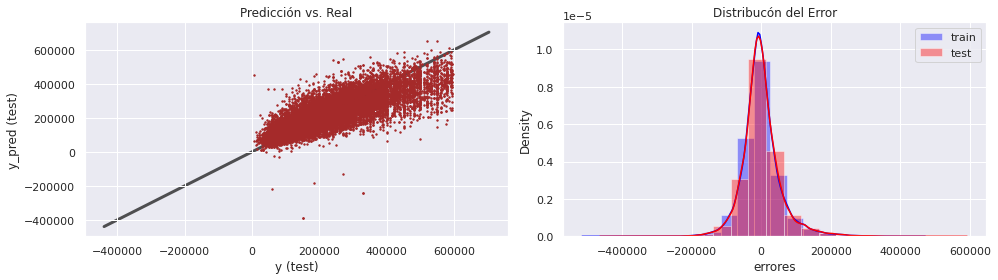

In [ ]:
poly = PolynomialFeatures(degree = 3, include_bias=False) 
X_train1 = poly.fit_transform(X_PCA_train)
X_test1= poly.fit_transform(X_PCA_test)

reg = LinearRegression()
reg.fit(X_train1, y_train)

evaluacion_modelo(reg,X_train1,X_test1,y_train,y_test)

### **Regularización**

**1 - Regularización Ridge**

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 9.78 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  55949.8732
Raíz del error cuadrático medio en Test: 56342.6875
La variación de esta métrica es igual a 196
------ --------  --------
La calidad del modelo en el conjunto de Train 72.3 %
La calidad del modelo en el conjunto de Test: 72.0 %
La variación de esta métrica es igual a 0.17 %
------ --------  --------
El R cuadrado ajustado para el Train es 72.2 %
El R cuadrado ajustado para el Test es 71.8 %
La variación de esta métrica es igual a 0.23 %


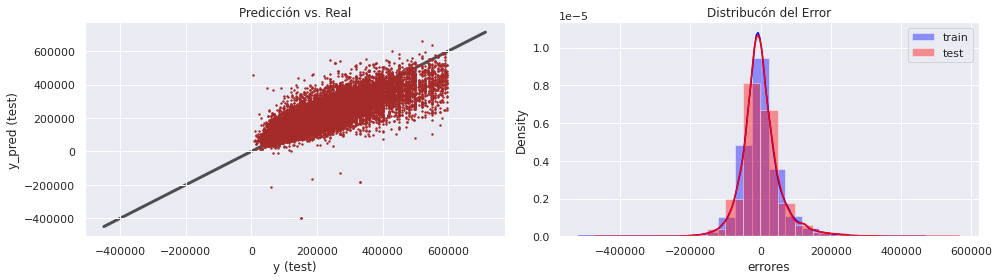

In [ ]:
reg_ridge = Ridge(alpha = 10**1, random_state=42)
reg_ridge.fit(X_train1,y_train)
evaluacion_modelo(reg_ridge,X_train1,X_test1,y_train,y_test)

In [ ]:
results = cross_validate(reg_ridge, X_train1, y_train, cv=5, 
                         return_train_score=True, 
                         scoring=('r2','neg_root_mean_squared_error'))
print('Mean r2 test: ', np.mean(results['test_r2']))
print('RMSE test: ',np.abs(np.mean(results['test_neg_root_mean_squared_error'])))

Mean r2 test:  0.7180560000386647
RMSE test:  56456.119146813384


**2- Regularización Lazo**


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131984816459782.23, tolerance: 96030490099.95125
  positive)


CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 9.54 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  55750.5289
Raíz del error cuadrático medio en Test: 56158.8256
La variación de esta métrica es igual a 204
------ --------  --------
La calidad del modelo en el conjunto de Train 72.5 %
La calidad del modelo en el conjunto de Test: 72.2 %
La variación de esta métrica es igual a 0.18 %
------ --------  --------
El R cuadrado ajustado para el Train es 72.39999999999999 %
El R cuadrado ajustado para el Test es 71.89999999999999 %
La variación de esta métrica es igual a 0.24 %


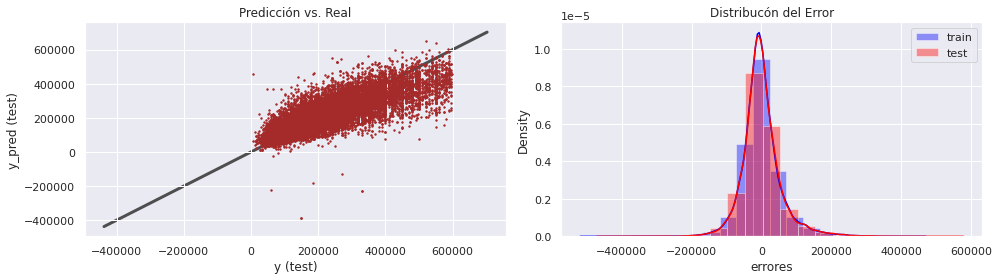

In [ ]:
reg_lasso = Lasso(alpha = 0.00001,max_iter= 2000)
reg_lasso.fit(X_train1,y_train)
evaluacion_modelo(reg_lasso,X_train1,X_test1,y_train,y_test)

In [ ]:
#results = cross_validate(reg_lasso, X_train1, y_train, cv=5, 
#                         return_train_score=True, 
#                         scoring=('r2','neg_root_mean_squared_error'))
#print('Mean r2 test: ', np.mean(results['test_r2']))
#print('RMSE test: ',np.abs(np.mean(results['test_neg_root_mean_squared_error'])))

Después de probar con diferentes valores para alfa Manualmente, y haber hecho el cross_validation, me quedo con la Regularización **Ridge**

Ahora, veremos como cambian los coeficientes en función de la regularización Ridge 

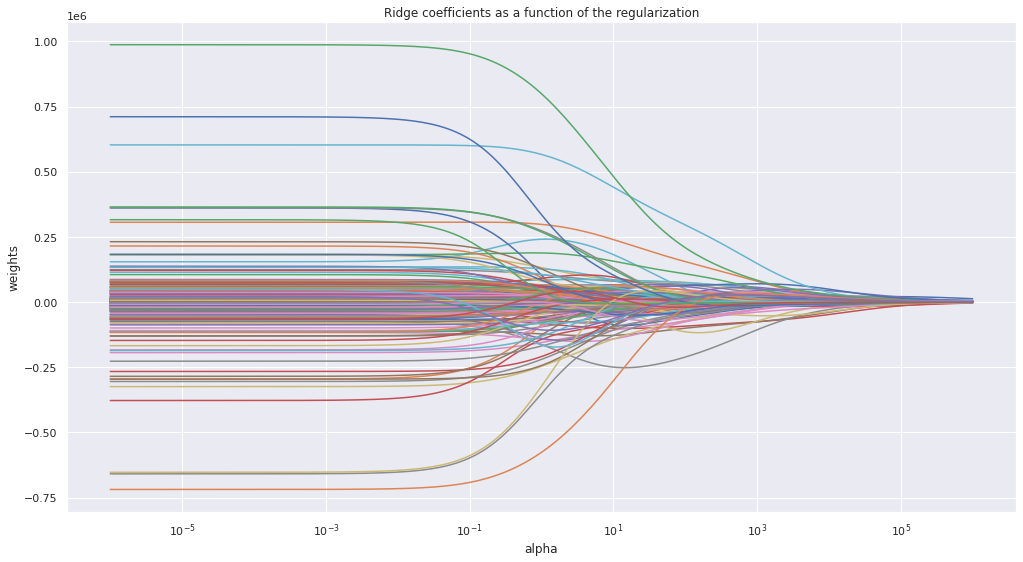

In [ ]:
n_alphas = 200
alphas = np.logspace(-6, 6, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train1,y_train)
    coefs.append(ridge.coef_)

plt.figure(figsize=(17,9))
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### **Grid Search en Ridge**

La idea de Ridge, es la de disminuir la siguiente función costo:


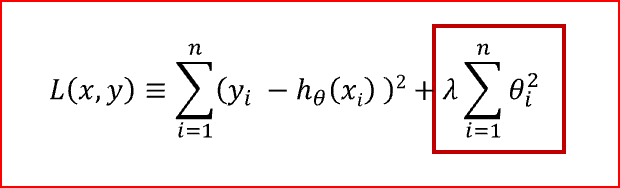

In [ ]:
#reg_ridge = Ridge(random_state=42)
#reg_ridge.fit(X_train1,y_train)

# Hiper parámetros de la grida
#grida= {
#    'alpha': [10**-4,10**-3,10**-2,10**-1,10**1],
#    'solver':['auto','svd','sag']
#    }

#grid = GridSearchCV(estimator=reg_ridge, param_grid=grida,
#                    scoring='r2', cv=4)
#
#grid.fit(X_train, y_train)
#print(grid.best_score_)
#print(grid.best_estimator_)
#print(grid.best_params_)

0.6842502433118962
Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='svd', tol=0.001)
{'alpha': 0.0001, 'solver': 'svd'}


### **Ridge Optimizado**

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 9.54 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  55593.726
Raíz del error cuadrático medio en Test: 56005.7259
La variación de esta métrica es igual a 411.99993139133585
------ --------  --------
La calidad del modelo en el conjunto de Train 72.7 %
La calidad del modelo en el conjunto de Test: 72.3 %
La variación de esta métrica es igual a 0.3583692271643568 %
------ --------  --------
El R cuadrado ajustado para el Train es 72.6 %
El R cuadrado ajustado para el Test es 72.1 %
La variación de esta métrica es igual a 0.3583692271643568 %


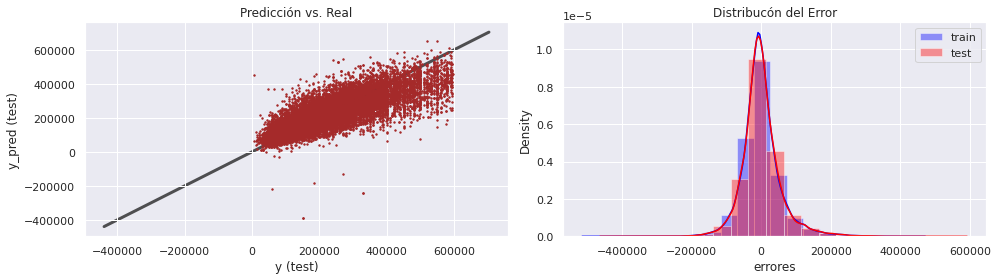

In [ ]:
reg_ridge = Ridge(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=42, solver='svd', tol=0.001)
reg_ridge.fit(X_train1,y_train)
evaluacion_modelo(reg_ridge,X_train1,X_test1,y_train,y_test)

### **Cross Validation para Ridge**

Ahora, almacenarems los valores de Ridge en un diccionario

In [ ]:
y_train_pred = reg_ridge.predict(X_train1)
y_test_pred = reg_ridge.predict(X_test1)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

In [ ]:
Ridge = {
    'Modelo':'Ridge',
    'RMSE Train':rmse_train,
    'R2 Train':r2_train,
    'RMSE Test':rmse_test,
    'R2 Test':r2_test   
}

In [ ]:
print(Ridge)

{'Modelo': 'Ridge', 'RMSE Train': 55593.72596590097, 'R2 Train': 0.7266629964354556, 'RMSE Test': 56005.72589729231, 'R2 Test': 0.723079304163812}


## **3- Bagging: Random Forest**

### **Default Random Forest**

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.82 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  14938.9505
Raíz del error cuadrático medio en Test: 38044.7427
La variación de esta métrica es igual a 11553
------ --------  --------
La calidad del modelo en el conjunto de Train 98.0 %
La calidad del modelo en el conjunto de Test: 87.2 %
La variación de esta métrica es igual a 5.4 %
------ --------  --------
El R cuadrado ajustado para el Train es 98.0 %
El R cuadrado ajustado para el Test es 87.2 %
La variación de esta métrica es igual a 5.42 %


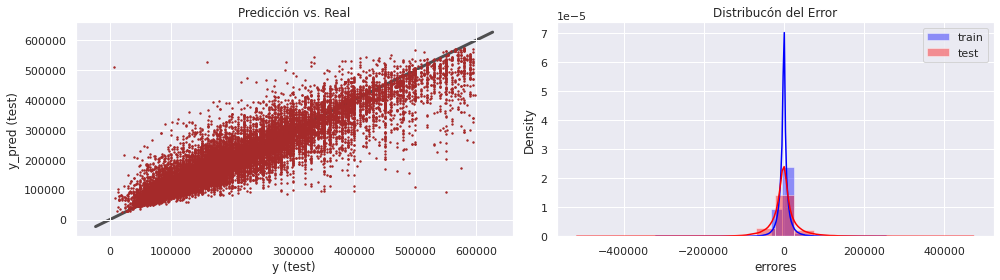

In [ ]:
clf= RandomForestRegressor(random_state=42)
clf.fit(X_train,y_train)
evaluacion_modelo(clf,X_train,X_test,y_train,y_test)

Un poco overfitteado, vamos a poner un max_depth

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  38430.7353
Raíz del error cuadrático medio en Test: 44724.1454
La variación de esta métrica es igual a 6293.410073244071
------ --------  --------
La calidad del modelo en el conjunto de Train 86.9 %
La calidad del modelo en el conjunto de Test: 82.3 %
La variación de esta métrica es igual a 4.597510757355961 %
------ --------  --------
El R cuadrado ajustado para el Train es 86.9 %
El R cuadrado ajustado para el Test es 82.3 %
La variación de esta métrica es igual a 4.597510757355961 %


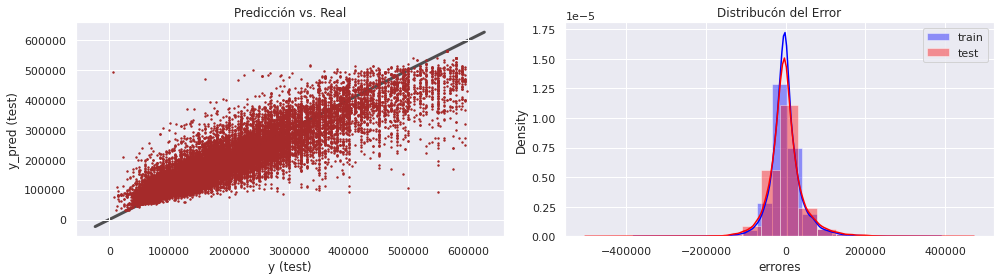

In [ ]:
clf= RandomForestRegressor(random_state=42,max_depth=12)
clf.fit(X_train,y_train)
evaluacion_modelo(clf,X_train,X_test,y_train,y_test)

**Cross-Validate en Random Forest**

In [ ]:
results = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring='r2', n_jobs=-1)
print('Mean r2 test: ', np.mean(results['test_score']))

Mean r2 test:  0.8650758054095903


In [ ]:
results = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring='neg_root_mean_squared_error', n_jobs=-1)
print('RMSE test: ',np.abs(np.mean(results['test_score'])))

RMSE test:  44483.58014548748


### **Randomized Search en Random Forest**

Para poder abarcar más parametros en gridsearch, voy a realizarlo sobre el conjunto PCA.

In [ ]:
# Hiper parámetros de la grida
#n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]
#max_depth= [None,1,5,12]
#min_samples_leaf = [1,3]
#oob_score = [True,False]
#bootstrap = [True,False]'''

In [ ]:
#%%time
#clf= RandomForestRegressor(n_jobs=-1)

#param_grid = {'n_estimators': n_estimators,
#               'max_depth': max_depth,
#               'min_samples_leaf': min_samples_leaf,
#               'oob_score': oob_score,
#               'bootstrap': bootstrap}
#print(param_grid)

#random = RandomizedSearchCV(clf, param_distributions=param_grid, 
#                    scoring='r2',n_jobs=-1, n_iter=5,cv=3)
#random.fit(X_PCA_train,y_train)
#print(random.best_score_)
#print(random.best_estimator_)
#print(random.best_params_)'''

{'n_estimators': [50, 100, 150, 200], 'max_depth': [None, 1, 5, 12], 'min_samples_leaf': [1, 3], 'oob_score': [True, False], 'bootstrap': [True, False]}
0.8317046985307192
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=6, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
{'oob_score': False, 'n_estimators': 200, 'min_samples_leaf': 3, 'max_depth': None, 'bootstrap': True}
CPU times: user 4min 45s, sys: 2.27 s, total: 4min 47s
Wall time: 13min


### **Grid Search en Random Forest**

In [ ]:
# Hiper parámetros de la grida
#n_estimators = [200,350,500]
#max_depth= [None,5,12]
#min_samples_leaf = [1,3]
#oob_score = [True,False]
#bootstrap = [True,False]

In [ ]:
%%time
#clf= RandomForestRegressor(n_jobs=-1)

#param_grid = {'n_estimators': n_estimators,
#               'max_depth': max_depth,
#               'min_samples_leaf': min_samples_leaf,
#               'oob_score': oob_score,
#               'bootstrap': bootstrap}
#print(param_grid)

#random = RandomizedSearchCV(clf, param_distributions=param_grid, 
#                    scoring='r2',n_jobs=-1, n_iter=5,cv=3)
#random.fit(X_PCA_train,y_train)
#print(random.best_score_)
#print(random.best_estimator_)
#print(random.best_params_)

{'n_estimators': [200, 350, 500], 'max_depth': [None, 5, 12], 'min_samples_leaf': [1, 3], 'oob_score': [True, False], 'bootstrap': [True, False]}


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.8389537802725359
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)
{'oob_score': True, 'n_estimators': 200, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
CPU times: user 5min 15s, sys: 3.41 s, total: 5min 19s
Wall time: 28min 59s


### **Random Forest Optimizado por GS**

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  14753.9371
Raíz del error cuadrático medio en Test: 37826.7135
La variación de esta métrica es igual a 23072.776337277486
------ --------  --------
La calidad del modelo en el conjunto de Train 98.1 %
La calidad del modelo en el conjunto de Test: 87.4 %
La variación de esta métrica es igual a 10.707313578256638 %
------ --------  --------
El R cuadrado ajustado para el Train es 98.1 %
El R cuadrado ajustado para el Test es 87.3 %
La variación de esta métrica es igual a 10.707313578256638 %


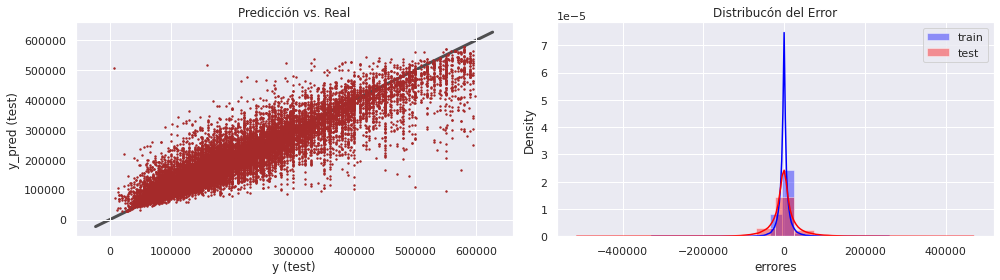

In [113]:
clf=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)
clf.fit(X_train,y_train)
evaluacion_modelo(clf,X_train,X_test,y_train,y_test)

### **Cross Validation en Random Forest GS**

In [ ]:
results = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring='r2', n_jobs=-1)
print('Mean r2 test: ', np.mean(results['test_score']))
MR2T=np.mean(results['test_score'])

In [114]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

In [115]:
RandomForest_GS = {
    'Modelo':'RandomForest G-S',
    'RMSE Train':rmse_train,
    'R2 Train':r2_train,
    'RMSE Test':rmse_test,
    'R2 Test':r2_test   
}

In [116]:
RandomForest_GS

{'Modelo': 'RandomForest G-S',
 'R2 Test': 0.8736754462871504,
 'R2 Train': 0.9807485820697168,
 'RMSE Test': 37826.71346867441,
 'RMSE Train': 14753.937131396922}

### **Random Forest Optimizado por RS**




CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  23483.4671
Raíz del error cuadrático medio en Test: 39175.9303
La variación de esta métrica es igual a 15692.463259756874
------ --------  --------
La calidad del modelo en el conjunto de Train 95.1 %
La calidad del modelo en el conjunto de Test: 86.5 %
La variación de esta métrica es igual a 8.6724765173129 %
------ --------  --------
El R cuadrado ajustado para el Train es 95.1 %
El R cuadrado ajustado para el Test es 86.4 %
La variación de esta métrica es igual a 8.6724765173129 %


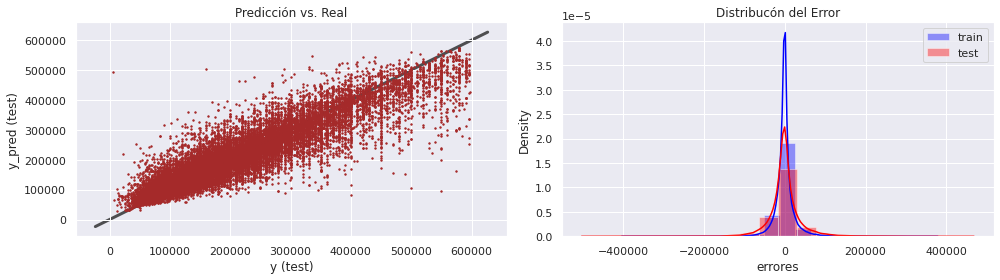

In [138]:
clf= RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=6, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
clf.fit(X_train,y_train)
evaluacion_modelo(clf,X_train,X_test,y_train,y_test)

### **Cross-Validation en Random Forest RS**

In [108]:
results = cross_validate(clf, X_train, y_train, cv=5, return_train_score=True, scoring='r2', n_jobs=-1)
print('Mean r2 test: ', np.mean(results['test_score']))
MR2T=np.mean(results['test_score'])

Mean r2 test:  0.8650232110548682


Ahora, vamos a guardar las métricas de este modelo en un diccionario


In [110]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

In [111]:
RandomForest_RS = {
    'Modelo':'RandomForest R-S',
    'RMSE Train':rmse_train,
    'R2 Train':r2_train,
    'RMSE Test':rmse_test,
    'R2 Test':r2_test   
}

In [112]:
RandomForest_RS 

{'Modelo': 'RandomForest R-S',
 'R2 Test': 0.8643111978402935,
 'R2 Train': 0.9511018144736751,
 'RMSE Test': 39203.67026253113,
 'RMSE Train': 23513.806469099978}

## **4- Boosting: XGBoost**

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  18244.8021
Raíz del error cuadrático medio en Test: 38880.2589
La variación de esta métrica es igual a 10318
------ --------  --------
La calidad del modelo en el conjunto de Train 97.1 %
La calidad del modelo en el conjunto de Test: 86.7 %
La variación de esta métrica es igual a 5.2 %
------ --------  --------
El R cuadrado ajustado para el Train es 97.1 %
El R cuadrado ajustado para el Test es 86.6 %
La variación de esta métrica es igual a 5.22 %


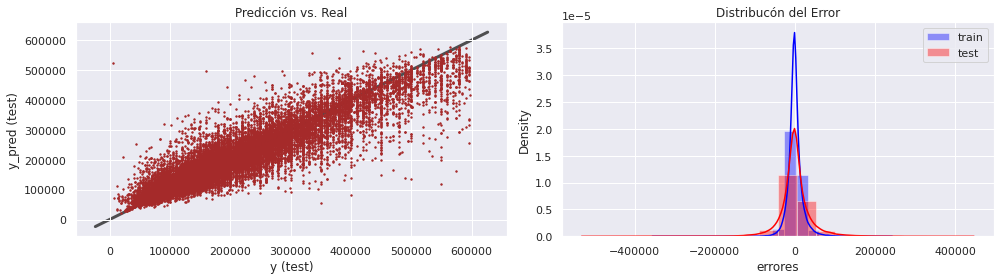

In [ ]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", max_depth=14, metricrandom_state=30)
xgb_model.fit(X_train, y_train)
evaluacion_modelo(xgb_model,X_train,X_test,y_train,y_test)

**Cross-Validate en XGBoost**

In [ ]:
results = cross_validate(xgb_model, X_train, y_train, cv=5, return_train_score=True, scoring='r2', n_jobs=-1)
print('Mean r2 test: ', np.mean(results['test_score']))

Mean r2 test:  0.8737250395561477


### **Grid Search en XGBoost**

In [ ]:
#Grid Search 
#xgb_model = xgb.XGBRegressor()
#xgb_model.fit(X_train, y_train)
# Hiper parámetros de la grida
#grida= {
#    'objective':["reg:squarederror"],
#    'max_depth':[10,15,20],
#    'metricrandom_state':[30],
#    'eta':[0.3,0.5,0.8],
#    'eval_metric':['rmse']
#    }
    
#grid = GridSearchCV(estimator=xgb_model, param_grid=grida,
#                    scoring='r2', cv=4)

#grid.fit(X_train, y_train)
#print(grid.best_score_)
#print(grid.best_estimator_)
#print(grid.best_params_)'''

[21:51:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8736154438503803
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3,
             eval_metric='rmse', gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=15,
             metricrandom_state=30, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)
{'eta': 0.3, 'eval_metric': 'rmse', 'max_depth': 15, 'metricrandom_state': 30, 'objective': 'reg:squarederror'}


image.png

### XGBoost Optimizado

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  18244.8021
Raíz del error cuadrático medio en Test: 38880.2589
La variación de esta métrica es igual a 20635.45677572465
------ --------  --------
La calidad del modelo en el conjunto de Train 97.1 %
La calidad del modelo en el conjunto de Test: 86.7 %
La variación de esta métrica es igual a 10.402015785798802 %
------ --------  --------
El R cuadrado ajustado para el Train es 97.1 %
El R cuadrado ajustado para el Test es 86.6 %
La variación de esta métrica es igual a 10.402015785798802 %


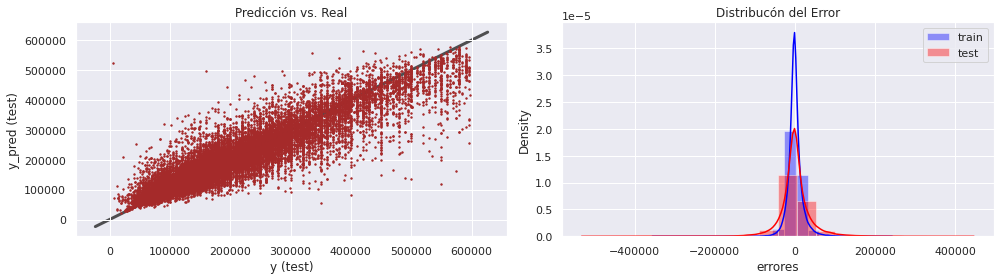

In [118]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", max_depth=14,
                             metricrandom_state=30,eta =0.3,eval_metric ='rmse')
xgb_model.fit(X_train, y_train)
evaluacion_modelo(xgb_model,X_train,X_test,y_train,y_test)

**Cross Validate en XGBoost optimizado**

In [ ]:
results = cross_validate(xgb_model, X_train, y_train, cv=5, return_train_score=True, scoring='r2', n_jobs=-1)
print('Mean r2 test: ', np.mean(results['test_score']))

Mean r2 test:  0.8737250395561477


Guardo las métricas del modelo en un diccionario


In [119]:
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

In [120]:
XGBoost = {
    'Modelo':'XGBoost',
    'RMSE Train':rmse_train,
    'R2 Train':r2_train,
    'RMSE Test':rmse_test,
    'R2 Test':r2_test   
}

In [121]:
XGBoost

{'Modelo': 'XGBoost',
 'R2 Test': 0.8665406980656373,
 'R2 Train': 0.9705608559236253,
 'RMSE Test': 38880.2588741241,
 'RMSE Train': 18244.802098399447}

## 5- Comparación de los modelos

Creamos un DataFrame con los diccionarios que almacenan las métricas de todos los modelos

In [122]:
Benchmark= pd.DataFrame.from_dict([Benchmark])
Arbol_O = pd.DataFrame.from_dict([Arbol_O ])
Ridge= pd.DataFrame.from_dict([Ridge])
RandomForest_RS= pd.DataFrame.from_dict([RandomForest_RS])
RandomForest_GS= pd.DataFrame.from_dict([RandomForest_GS])
XGBoost= pd.DataFrame.from_dict([XGBoost])


In [123]:
modelos= pd.concat([Benchmark,Arbol_O])
modelos= pd.concat([modelos,Ridge])
modelos= pd.concat([modelos,RandomForest_RS])
modelos= pd.concat([modelos,RandomForest_GS])
modelos= pd.concat([modelos,XGBoost])
modelos = modelos.reset_index(drop=True)
modelos.head()

,Modelo,RMSE Train,R2 Train,RMSE Test,R2 Test
0,Arbol P01 Benchmark,43274.419498,0.834381,51013.008691,0.770252
1,Arbol Optimizado,34738.346108,0.893275,49032.789772,0.787742
2,Ridge,55593.725966,0.726663,56005.725897,0.723079
3,RandomForest R-S,23513.806469,0.951102,39203.670263,0.864311
4,RandomForest G-S,14753.937131,0.980749,37826.713469,0.873675


### **1- Performance de modelos**

**Mejor RMSE en Test**

In [124]:
modelos.sort_values(by=['RMSE Test'])

,Modelo,RMSE Train,R2 Train,RMSE Test,R2 Test
4,RandomForest G-S,14753.937131,0.980749,37826.713469,0.873675
5,XGBoost,18244.802098,0.970561,38880.258874,0.866541
3,RandomForest R-S,23513.806469,0.951102,39203.670263,0.864311
1,Arbol Optimizado,34738.346108,0.893275,49032.789772,0.787742
0,Arbol P01 Benchmark,43274.419498,0.834381,51013.008691,0.770252
2,Ridge,55593.725966,0.726663,56005.725897,0.723079


Podemos ver que el mejor modelo basandonos en RMSE es Random Forest (Grid-Search), con un RMSE de 37.826,71. Supera ampliamente el Benchmark de este proyecto, por 13.187.

**Mejor R2 en Test**

In [125]:
modelos.sort_values(by=['R2 Test'],ascending=False)

,Modelo,RMSE Train,R2 Train,RMSE Test,R2 Test
4,RandomForest G-S,14753.937131,0.980749,37826.713469,0.873675
5,XGBoost,18244.802098,0.970561,38880.258874,0.866541
3,RandomForest R-S,23513.806469,0.951102,39203.670263,0.864311
1,Arbol Optimizado,34738.346108,0.893275,49032.789772,0.787742
0,Arbol P01 Benchmark,43274.419498,0.834381,51013.008691,0.770252
2,Ridge,55593.725966,0.726663,56005.725897,0.723079


En esta métrica, el mejor modelo también es Random Forest (Grid-Search), con un performance de 87,36%, respecto del 77,02% que tenía el benchmark

En conclusión, bajo la mirada del performance, eligiría, **Random Forest (Grid-Search),,** ya que en ambas métricas es el de mayor **rendimiento**

### **2-Varianza de modelos**

Lo que vamos a hacer ahora, es calcular la diferencia que hay entre Train y Test, para poder darnos una idea de cuanta varianza hay entre los conjuntos de train y test, y por supuesto, determinar cuales de estos modelos presentan cierto grado de overfitting

In [126]:
modelos['V RMSE']=np.abs(modelos['RMSE Train'] - modelos['RMSE Test'])
modelos['V R2 %']= np.abs(modelos['R2 Train'] - modelos['R2 Test'])*100

**Varianza en RMSE**

In [127]:
modelos.sort_values(by=['V RMSE'],ascending=True)

,Modelo,RMSE Train,R2 Train,RMSE Test,R2 Test,V RMSE,V R2 %
2,Ridge,55593.725966,0.726663,56005.725897,0.723079,411.999931,0.358369
0,Arbol P01 Benchmark,43274.419498,0.834381,51013.008691,0.770252,7738.589193,6.412967
1,Arbol Optimizado,34738.346108,0.893275,49032.789772,0.787742,14294.443663,10.553310
3,RandomForest R-S,23513.806469,0.951102,39203.670263,0.864311,15689.863793,8.679062
5,XGBoost,18244.802098,0.970561,38880.258874,0.866541,20635.456776,10.402016
4,RandomForest G-S,14753.937131,0.980749,37826.713469,0.873675,23072.776337,10.707314


Como era de esperarse, el modelo de Ridge, es el que menor varianza tiene respecto al RMSE.

**Varianza en R2**

In [128]:
modelos.sort_values(by=['V R2 %'],ascending=True)

,Modelo,RMSE Train,R2 Train,RMSE Test,R2 Test,V RMSE,V R2 %
2,Ridge,55593.725966,0.726663,56005.725897,0.723079,411.999931,0.358369
0,Arbol P01 Benchmark,43274.419498,0.834381,51013.008691,0.770252,7738.589193,6.412967
3,RandomForest R-S,23513.806469,0.951102,39203.670263,0.864311,15689.863793,8.679062
5,XGBoost,18244.802098,0.970561,38880.258874,0.866541,20635.456776,10.402016
1,Arbol Optimizado,34738.346108,0.893275,49032.789772,0.787742,14294.443663,10.553310
4,RandomForest G-S,14753.937131,0.980749,37826.713469,0.873675,23072.776337,10.707314


Al igual que en el RMSE, Ridge presenta la menor varianza respecto a R2

### **Fiabilidad**

Agregamos dos columnas:


1.  **['D P'] =** que significa la distancia o diferencia con el mejor performance
2.   **['D V'] =** que significa la distancia o diferencia con la menor varianza
3.   **['puntuación'] =** que va a ser el puntaje de nuestro " trade-off " entre buen performance y baja varianza. Debido a que ['D P'] y ['D V'] tratan de ser lo más bajo posible, voy a escalar ambas columnas (entre 1 el valor más bajo y 2 el valor más alto) y  multiplicar ambos valores, para que, el producto más pequeño de esta multiplicación, sea el elegido.



In [134]:
modelos['D P']=round(np.abs(38880.258874 - modelos['RMSE Test']),2)
modelos['D V']= round(np.abs(411.999931 - modelos['V RMSE']),2)

Escalamos....

In [135]:
from sklearn.preprocessing import MinMaxScaler
columnas= ['D P', 'D V']
scaler= MinMaxScaler(feature_range=(1,2))

for columna in columnas:
  modelos[[columna]] = scaler.fit_transform(modelos[[columna]])

round(modelos.describe(),2)

,RMSE Train,R2 Train,RMSE Test,R2 Test,V RMSE,V R2 %,D P,D V
count,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00
mean,31686.51,0.89,45327.03,0.81,13640.52,7.85,1.40,1.58
std,15807.17,0.10,7686.46,0.06,8394.65,4.02,0.43,0.37
min,14753.94,0.73,37826.71,0.72,412.00,0.36,1.00,1.00
25%,19562.05,0.85,38961.11,0.77,9377.55,6.98,1.03,1.40
50%,29126.08,0.92,44118.23,0.83,14992.15,9.54,1.33,1.64
75%,41140.40,0.97,50517.95,0.87,19399.06,10.52,1.68,1.84
max,55593.73,0.98,56005.73,0.87,23072.78,10.71,2.00,2.00


In [136]:
modelos['puntaje']= round((np.abs(modelos['D P']*modelos['D V'])),3)
modelos.head(7)

,Modelo,RMSE Train,R2 Train,RMSE Test,R2 Test,V RMSE,V R2 %,D P,D V,puntaje
0,Arbol P01 Benchmark,43274.419498,0.834381,51013.008691,0.770252,7738.589193,6.412967,1.708462,1.323316,2.261
1,Arbol Optimizado,34738.346108,0.893275,49032.789772,0.787742,14294.443663,10.553310,1.592832,1.612620,2.569
2,Ridge,55593.725966,0.726663,56005.725897,0.723079,411.999931,0.358369,2.000000,1.000000,2.000
3,RandomForest R-S,23513.806469,0.951102,39203.670263,0.864311,15689.863793,8.679062,1.018885,1.674198,1.706
4,RandomForest G-S,14753.937131,0.980749,37826.713469,0.873675,23072.776337,10.707314,1.061519,2.000000,2.123
5,XGBoost,18244.802098,0.970561,38880.258874,0.866541,20635.456776,10.402016,1.000000,1.892443,1.892


En la tabla de arriba, podemos ver que los valores para distancia a performance de RandomForest G-S es 1 (valor mínimo), como tambien la distancia a la varianza de Ridge es 1.

In [137]:
modelos.sort_values(by=['puntaje'],ascending=True)

,Modelo,RMSE Train,R2 Train,RMSE Test,R2 Test,V RMSE,V R2 %,D P,D V,puntaje
3,RandomForest R-S,23513.806469,0.951102,39203.670263,0.864311,15689.863793,8.679062,1.018885,1.674198,1.706
5,XGBoost,18244.802098,0.970561,38880.258874,0.866541,20635.456776,10.402016,1.000000,1.892443,1.892
2,Ridge,55593.725966,0.726663,56005.725897,0.723079,411.999931,0.358369,2.000000,1.000000,2.000
4,RandomForest G-S,14753.937131,0.980749,37826.713469,0.873675,23072.776337,10.707314,1.061519,2.000000,2.123
0,Arbol P01 Benchmark,43274.419498,0.834381,51013.008691,0.770252,7738.589193,6.412967,1.708462,1.323316,2.261
1,Arbol Optimizado,34738.346108,0.893275,49032.789772,0.787742,14294.443663,10.553310,1.592832,1.612620,2.569


Bajo el enfoque descripto en este análisis, el modelo más fiable de todos, en cuanto al trade-off entre performance y varianza, es el Random Forest con Optimización de parámetros mediante Randomized GridSearch. Seguido por XGboost.
 

### **Conclusión Final.**

Después de analizar el performance, la varianza y la fiabilidad, me quedaría con el **RandomForest R-S** por la robustes del modelo ya que, aún manteniendo un performance relativamente alto (RMSE = 39.203,67) no mantiene tanta varianza con el conjunto Test ( en comparación al resto de los modelos).
Por quer, si bien Ridge tiene varianza mínima, el problema es que tiene un valos de bias bastante alto.

# **Parte C**

## **Análisis de Features**

Dado el modelo elegido, vamos a analizar cuales variables fueron las más relevantes para la predicción:

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
------ --------  --------
Raíz del error cuadrático medio en Train:  23497.15
Raíz del error cuadrático medio en Test: 39181.501
La variación de esta métrica es igual a 15684.351075886108
------ --------  --------
La calidad del modelo en el conjunto de Train 95.1 %
La calidad del modelo en el conjunto de Test: 86.4 %
La variación de esta métrica es igual a 8.670645074163385 %
------ --------  --------
El R cuadrado ajustado para el Train es 95.1 %
El R cuadrado ajustado para el Test es 86.4 %
La variación de esta métrica es igual a 8.670645074163385 %


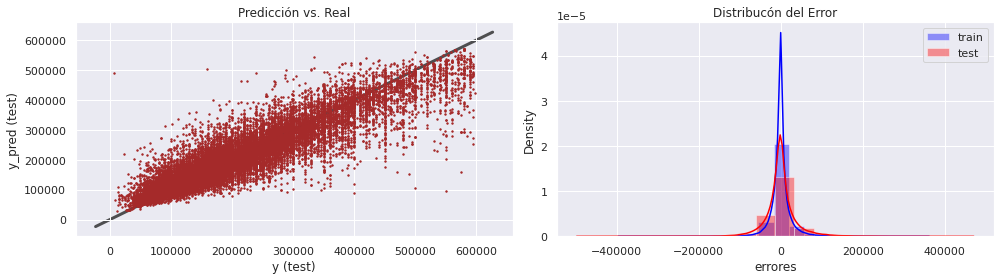

In [140]:
modelo= RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=6, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
modelo.fit(X_train,y_train)
evaluacion_modelo(modelo,X_train,X_test,y_train,y_test)

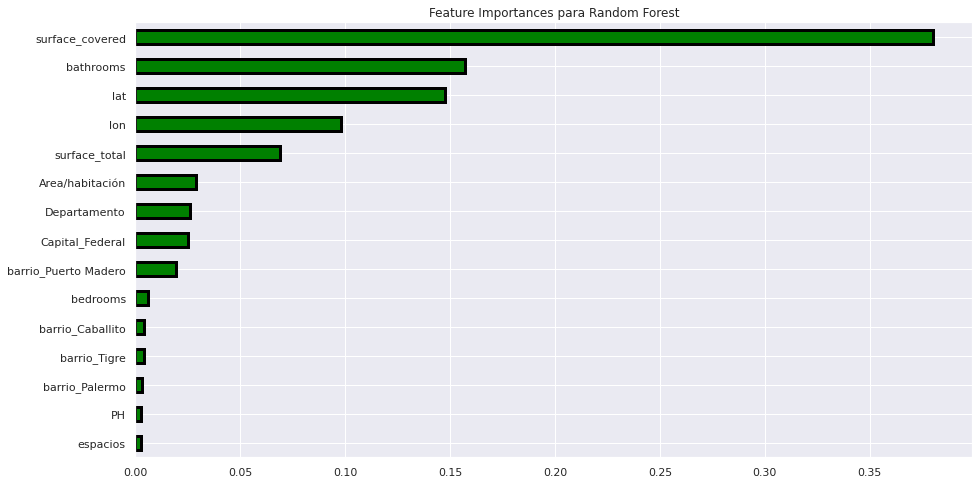

In [167]:
plt.figure(figsize = (15,8))
feat_importances = pd.Series(modelo.feature_importances_, index=[str(col) for col in df.columns if col!='price'])
feat_importances.nlargest(15).plot(kind='barh',color='green',edgecolor='black',linewidth=3).invert_yaxis()
plt.title('Feature Importances para Random Forest')
plt.show()

Dadas las variables utilizadas para proyectar el precio del inmuble en el random forest, seleccionemos 4 arboles aleatorios para ver que atributos considera más importantes

In [168]:
print('Nuestro modelo usó ' + str(len(modelo.estimators_)) + ' estimadores.')

Nuestro modelo usó 200 estimadores.


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=428812219, splitter='best')
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=823539180, splitter='best')
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, m

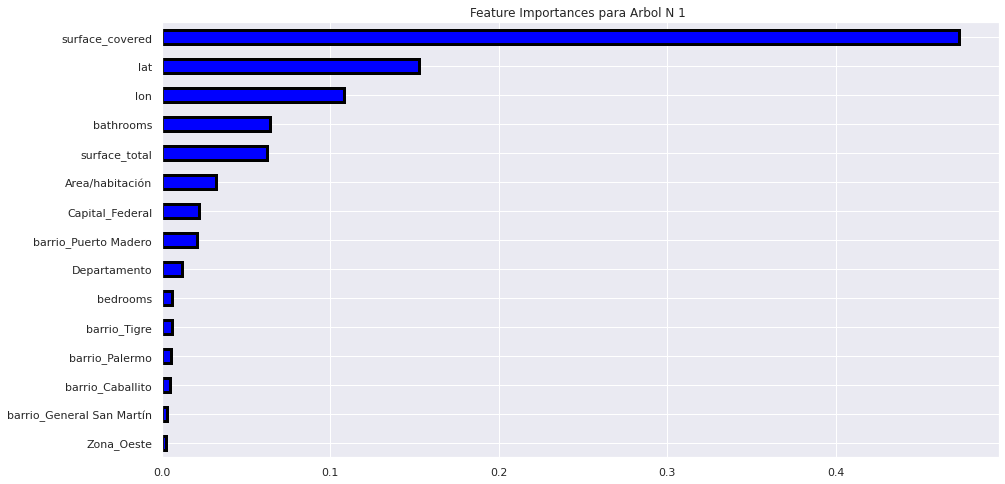

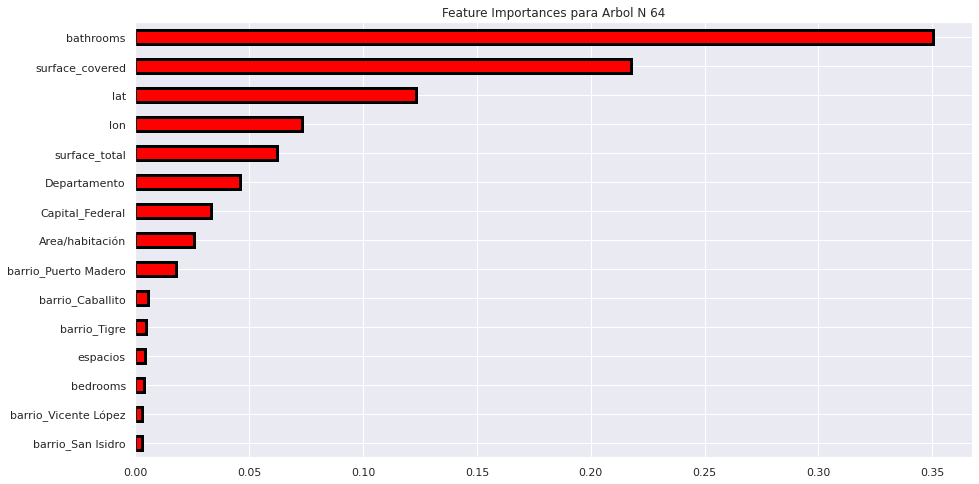

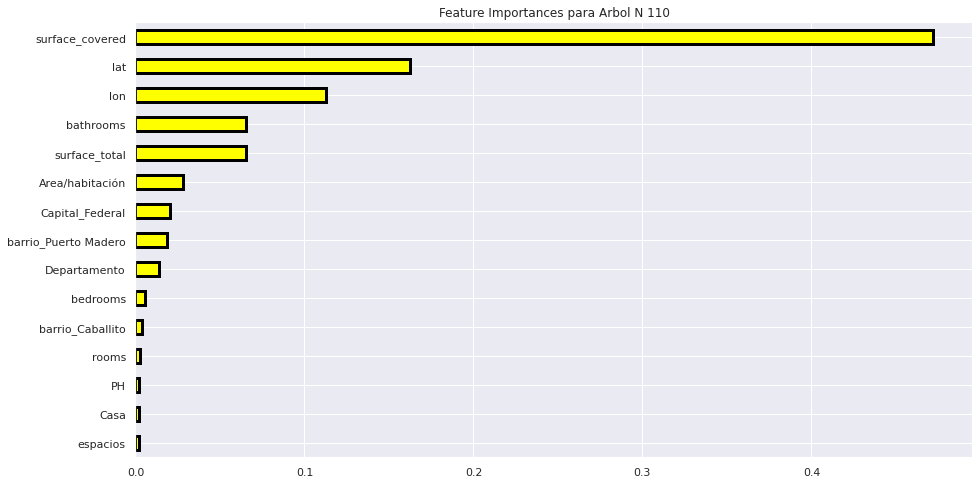

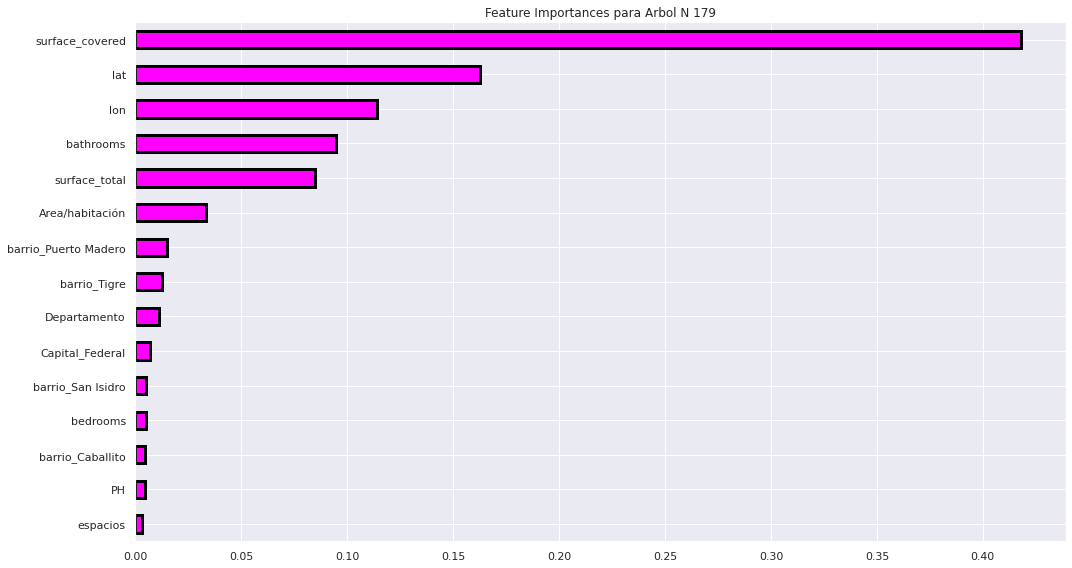

In [169]:
arbol1 = modelo.estimators_[0]
arbol2 = modelo.estimators_[64]
arbol3 = modelo.estimators_[110]
arbol4 = modelo.estimators_[179]
print(arbol1)
print(arbol2)
print(arbol3)
print(arbol4)


plt.figure(figsize = (15,8))
feat_importances1 = pd.Series(arbol1.feature_importances_, index=[str(col) for col in df.columns if col!='price'])
feat_importances1.nlargest(15).plot(kind='barh',color='blue',edgecolor='black',linewidth=3).invert_yaxis()
plt.title('Feature Importances para Arbol N 1 ')
plt.show()

plt.figure(figsize = (15,8))
feat_importances2 = pd.Series(arbol2.feature_importances_, index=[str(col) for col in df.columns if col!='price'])
feat_importances2.nlargest(15).plot(kind='barh',color='red',edgecolor='black',linewidth=3).invert_yaxis()
plt.title('Feature Importances para Arbol N 64')
plt.show()

plt.figure(figsize = (15,8))
feat_importances3 = pd.Series(arbol3.feature_importances_, index=[str(col) for col in df.columns if col!='price'])
feat_importances3.nlargest(15).plot(kind='barh',color='yellow',edgecolor='black',linewidth=3).invert_yaxis()
plt.title('Feature Importances para Arbol N 110')
plt.show()

plt.figure(figsize = (15,8))
feat_importances4 = pd.Series(arbol4.feature_importances_, index=[str(col) for col in df.columns if col!='price'])
feat_importances4.nlargest(15).plot(kind='barh',color='magenta',edgecolor='black',linewidth=3).invert_yaxis()
plt.title('Feature Importances para Arbol N 179')
plt.tight_layout()
plt.show()


Al igual que para el Random Forest, los primeros 5 parámetros más importantes se comparten en los 4 arboles seleccionados, esto nos da una buena intuición de que son buenos predictores a lo largo de todo el bagging.

Luego, la importancia varía según `Area/habitación`, `Deparamento`, `Capital Federal` y `Puerto Madero`.

Respecto al cambio de importancia de los atributos respecto al proyecto pasado, adjunto el mapa de correlaciones del proyecto 1:
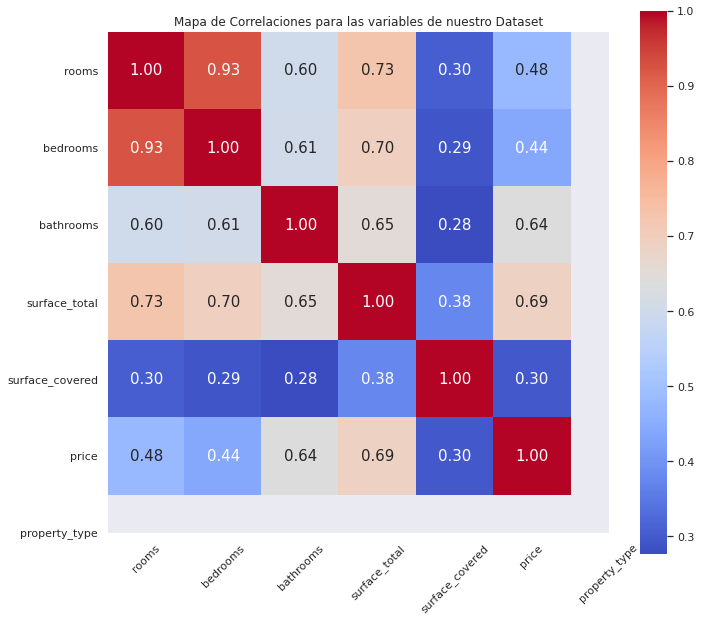

In [180]:
matrix=df.copy()

In [183]:
matrix = matrix.drop(matrix[matrix.columns[17::]],axis=1)

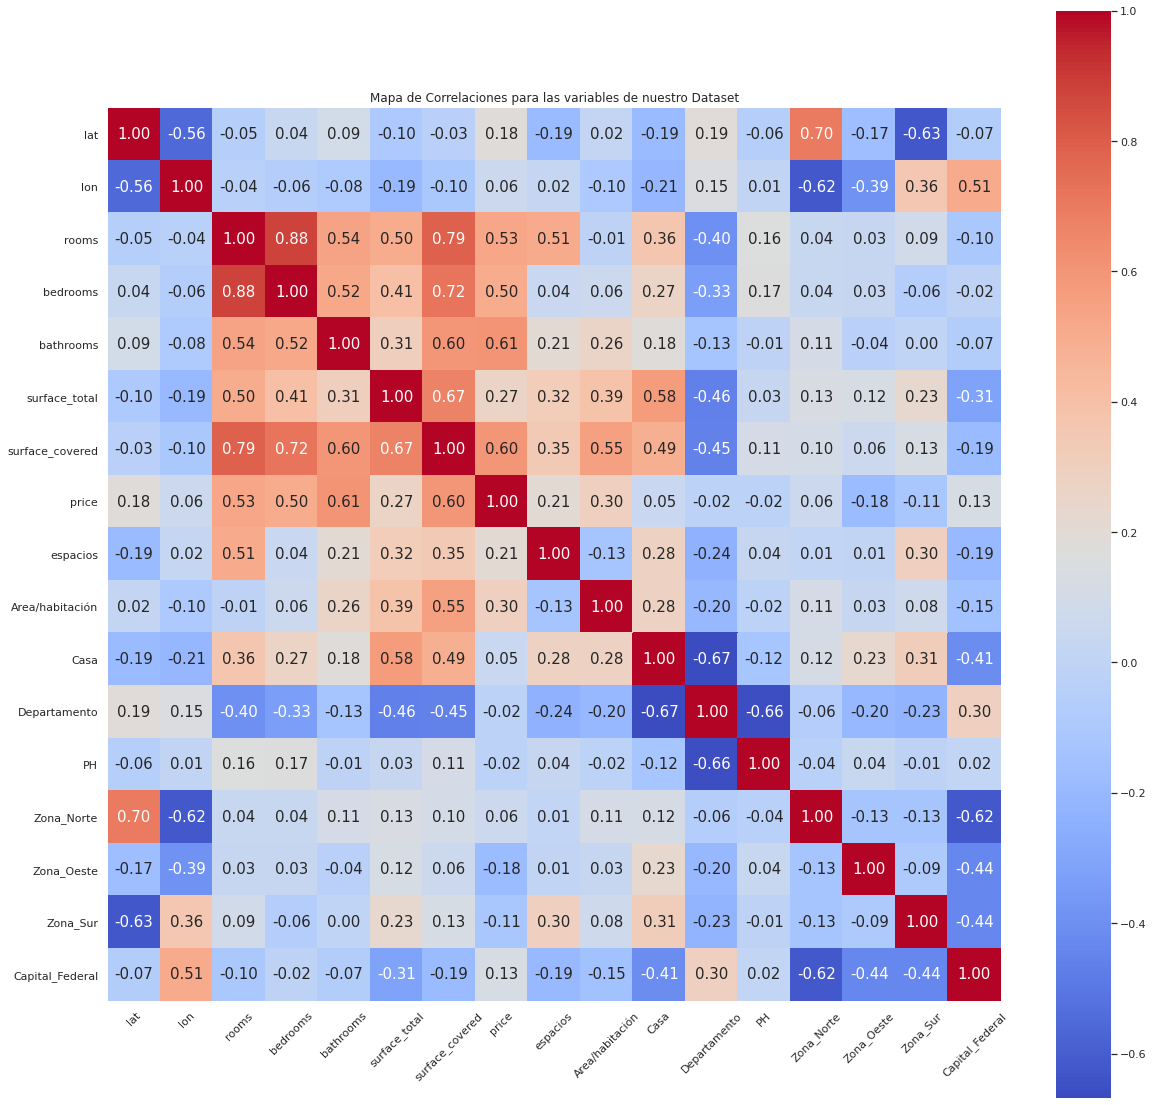

In [187]:
corrml = matrix.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrml, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, xticklabels= matrix.columns, 
            yticklabels= matrix.columns,
            cmap= 'coolwarm')
plt.title('Mapa de Correlaciones para las variables de nuestro Dataset')
plt.yticks(rotation = 0)
plt.xticks(rotation = 45)
plt.show()

Además de la cantidad de nuevas variables, podemos ver que el precio cambia las correlatividades con las variables que compartímos con el proyecto anterior.

Por ejemplo, surface_covered que antes era del 0.3, ahora es del 0.60.

## **Distribución de errores**

In [188]:
y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)

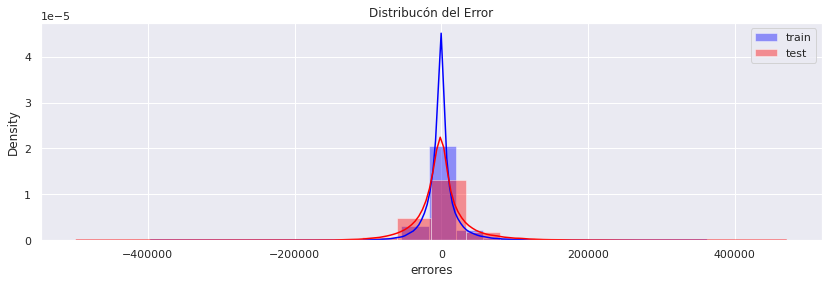

In [192]:
  plt.figure(figsize = (14,4))
  sns.distplot(y_train - y_train_pred, bins = 20, label = 'train',color='blue')
  sns.distplot(y_test - y_test_pred, bins = 20, label = 'test',color='red')
  plt.title('Distribucón del Error')
  plt.xlabel('errores')
  plt.legend()

  plt.show()

Esta curva gaussiana muestra como es la distribución de los errores al rededor del cero. Mientras más densa es la curva sobre el cero, menores son los errores.

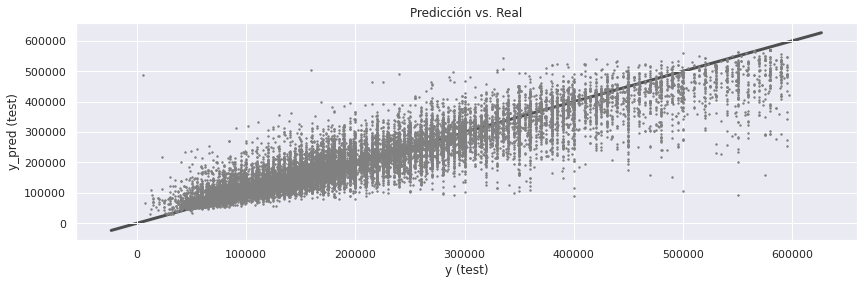

In [191]:
plt.figure(figsize = (14,4))
ax = plt.subplot(1,1,1)
ax.scatter(y_test,y_test_pred, s =2,color='gray')
    
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
        ]
    
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,linewidth= 3)
plt.title('Predicción vs. Real')
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)')
plt.show()

Podemos ver que el el gráfico de valores predichos vs. valores reales, hay algunos grupos de outliers, como objetivo a mejorar futuro, me propongo analizarlos y removerlos mediante clustering.

Esto es importante, ya que hay puntos cuyos valores predichos son por ejemplo, 100.000 USD, pero la realidad, es que fueron tasados a 550.000. Esto genera diferencias abismales en nuestro modelo.

## **Aspectos para mejorar:** 

Volvería a analizar algunos aspectos sobre el preprocesamiento de los datos, como por ejemplo, cual hubiese sido el impacto en el modelo que, en vez de usar el standard scaler, hubiese utilizado un MINMAX scaler. También las políticas que utilicé en el tratamiento de valores atípicos, que hubiese pasado si usaba una metodología más laxa? También me hubiese gustado analizar el escalado de datos que no tienen distribución normal o gaussiana, por ejemplo, la variable precio. Que hubiese pasado con el modelo si le aplicabamos el logaritmo para escalarlo? o si le aplicabamos la raíz?


Por otro lado, aplicaría técnicas de clustering para encontrar patrones en el prepocesamiento de datos y la remoción de valores atípicos del modelo